# generation of table of powerfits
Tim Tyree<br>
8.30.2021

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

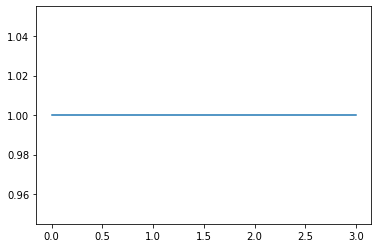

In [3]:
plt.plot([1]*4)
plt.show()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

__Introductary Notes__
- fits may be recomputed by evaluating the .ipynb associated with fitting powerlaws to the full models.
- here, the powerlaw fit is w=M*q**m, and Delta_X is the maximum disagreement one could expect to observe with 95% confidence.
- here, we observe Delta_X concerns disagreements between statistically independent measurements of X.

In [4]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


In [5]:
1/(1-1j/(2*np.pi))+1/(1+1j/(2*np.pi))

(1.9505909539362845+0j)

# gener_powerlaw_fit

In [6]:
# #generate a csv of all powerlaw fits for a folder containing .csv files returned by postprocessing the raw output data log printed in tim's custom c and perl code
# input_fn=search_for_file()

In [7]:
# gener_df_powerlaw_fits_and_to_csv

In [8]:
# # # #run 5 uses a weird beta parameter
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_5_all/job.out.8923457.1'
# # #run 6 looks right, but uses the ballistic method Dt/dt
# # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_6_all/job.out.8925250.182148'
# # #run 7 uses temperature_energy, energy_gap, and Dratio
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_7_all/job.out.9090167.49829'
# # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_6_all/job.out.9589138.999'

# #2D grid search over r,kappa at alinear,D from the full models
# # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all/job.out.22994937.1052' #WARNING CLUSTERID MATCHES RUN 25
# # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_25_all/job.out.22996017.9999'
# input_fn = '/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.0'

In [8]:
#get last input_fn listed for run_num
run_num=37
input_folder=f'{nb_dir}/data/osg_output/run_{run_num}_all'
# input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
for input_fn in os.listdir(input_folder):
    pass
input_fn = os.path.join(input_folder,input_fn)
print(f"{input_fn=}")

input_fn='/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_37_all/job.out.27612947.86'


In [9]:
df=pd.read_csv(input_fn)
df.head()
df.shape

(96, 17)

In [10]:
# # width=200
# # width=200
# # area=0.0025*width*height
# print(f"r runs from {df['r'].min()} to {df['r'].max()} cm")
# print(f"kappa runs from {df['kappa'].min()} to {df['kappa'].max()} Hz")

In [11]:
#recall powerlaw fits to full
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)
model_str = 'fk_pbc'
# model_str = 'lr_pbc'
wjr[model_str]

#recall annihilation rate results from vidmar and rappel (2019)
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2

fk_pbc lr_pbc fk_ncbc lr_ncbc


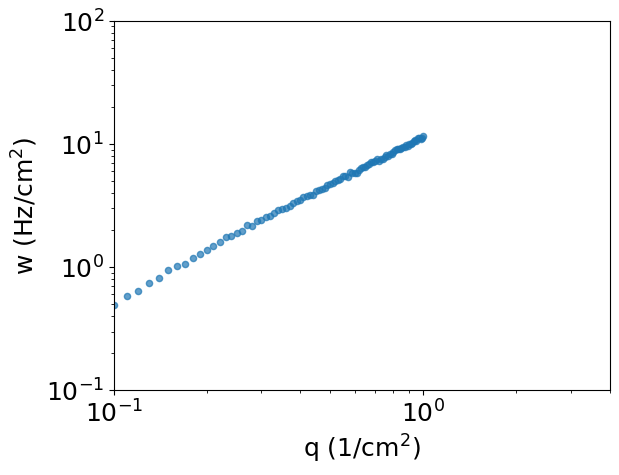

df.shape=(96, 19)


In [12]:
#determine a reasonable qmin,qmax
use_loglog=True
# use_loglog=False
df['q']=df['N']/(df['L']**2)
df['w']=(df['CollTime']**-1)/(df['L']**2)
df.plot.scatter(x='q',y='w',alpha=0.7)
format_plot(ax=plt.gca(),xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=18,use_loglog=use_loglog)
plt.xlim([0.1,4])
# plt.ylim([0.1,800])
# plt.xlim([0.1,1])
plt.ylim([0.1,100])
plt.show()
print(F"{df.shape=}")

In [13]:
col_lst=['varkappa','D','r','kappa','L']
for col in col_lst:
    val=df[col].min()
    print(f"{col}: {val}")
    

varkappa: 25
D: 0.6
r: 0.1
kappa: 200
L: 10


In [14]:
# qmin=0.1 # 0.1=default value may be modified through q_min kwarg
# qmax=0.75  #  may be accessed through q_min kwarg
# qmax=0.7  
# qmin=0.2 #default
# qmin=0.5
qmax=1

In [15]:
# gener_df_powerlaw_fits_and_to_csv
min_num_particles=20
# min_num_particles=50
# L_lst=[10,5] #cm
# run_num_lst=[33,29]
# run_num_lst=[35]
run_num_lst=[36]
# run_num_lst = [28,33,32,31,30,27]

In [16]:
# 'q_max':0.4,
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_23_all/job.out.21392526.13"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_22_all/job.out.21389603.156"
# 'q_max':None,
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_21_all/job.out.21377943.553"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all/job.out.21377943.2385"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all/job.out.19842066.24"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all/job.out.16106771.17"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all/job.out.15270959.1"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/black_star_run_1_all/out.0"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_16_all/job.out.14688026.14"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/job.out.13954413.14"

#get last input_fn listed for run_num
# for run_num,L in zip(run_num_lst,L_lst):
for run_num in run_num_lst:
    input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    for input_fn in os.listdir(input_folder):
        pass
    input_fn = os.path.join(input_folder,input_fn)
    #print(f"{input_fn=}")
    L = int(pd.read_csv(input_fn)['L'].drop_duplicates().head(1).values)
    qmin=min_num_particles / (L**2)
    
    printing=True
    kwargs={
        'q_min':float(qmin),
        'q_max':float(qmax),
    #     'q_max':1., #default
    #     'q_max':0.4,
    #     'q_max':None, #default
           }
    npartitions=os.cpu_count()
    save_dir=gener_df_powerlaw_fits_and_to_csv(input_fn,**kwargs)
    print(f"powerlaw_fit_dir='{save_dir}'")

testing input_fn
{'m': 1.9040243775875711, 'Delta_m': 0.012902134474541672, 'M': 11.93015354691604, 'Delta_M': 0.3751226094856275, 'Rsq': 0.9990804884701827, 'rmse': 0.1385679847182455, 'rmse_full': 2.4309687005662477, 'model_name_full': 'fk_ncbc', 'q_min': 0.2, 'q_max': 1.0, 'r': 0.155, 'kappa': 300, 'D': 0.42, 'varkappa': 3, 'x0': 0, 'L': 10, 'force_code': 2, 'neighbor': 1, 'reflect': 0, 'set_second': 0, 'no_repulsion': 0, 'no_attraction': 0, 'dt': 1e-05, 'Dt': 1e-05}
parsing absolute directory of input_fn=/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_36_all/job.out.25610807.1...
We're about to use 12 cores to obliterate 93 csv files from /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_36_all
run time for computing powerlaw fits was 3.83 seconds.
computed powerlaw fits for  93 trials successfully.
parsing absolute directory of input_fn=/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_36_all/job.out.25610807.1...
powerlaw fi

In [17]:
beep(3)



0

In [22]:
# then, one may optionally go here to use the outputed table:
# http://localhost:8888/notebooks/Generating%20Annihilation%20Rate%20Plots%20from%20Remote%20Cache%20of%20Particle%20Model.ipynb

# plot annihilation magnitude versus alinear and see whether the exponent value 4/3 appears universal

In [88]:
data_dir = f"{nb_dir}/data/osg_output/run_36_all_powerlaw_fits.csv"
# data_dir = f"{nb_dir}/data/osg_output/run_37_all_powerlaw_fits.csv"
df = pd.read_csv(data_dir)
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
0,1.408242,0.009698,13.097805,0.403812,0.999050,0.153599,1.592532,lr_ncbc,0.2,1.0,...,0,10,2,1,0,0,0,0,0.00001,0.00001
1,1.375548,0.008991,28.850169,0.959224,0.999144,0.280184,7.642600,lr_pbc,0.2,1.0,...,0,10,2,0,0,0,0,0,0.00001,0.00001
2,2.380340,0.016232,10.083187,0.357283,0.999069,0.135184,1.104257,fk_ncbc,0.2,1.0,...,0,10,2,0,0,0,0,0,0.00001,0.00001
3,1.371649,0.009306,23.675612,0.781377,0.999078,0.236660,4.647442,lr_pbc,0.2,1.0,...,0,10,2,1,0,0,0,0,0.00001,0.00001
4,1.612789,0.012991,15.209254,0.584864,0.998701,0.229536,0.706446,lr_ncbc,0.2,1.0,...,0,10,2,0,0,0,0,0,0.00001,0.00001


In [85]:
df.columns

Index(['m', 'Delta_m', 'M', 'Delta_M', 'Rsq', 'rmse', 'rmse_full',
       'model_name_full', 'q_min', 'q_max', 'r', 'kappa', 'D', 'varkappa',
       'x0', 'L', 'force_code', 'neighbor', 'reflect', 'set_second',
       'no_repulsion', 'no_attraction', 'dt', 'Dt'],
      dtype='object')

In [89]:
# show_plots=True
show_plots=False
if show_plots:
    param_col_lst = ['r', 'kappa', 'D', 'L', 'neighbor',] 
    #             'x0',   'force_code',   'reflect', 'set_second','no_repulsion', 'no_attraction']
    groups = df.sort_values(by='varkappa').groupby(by=param_col_lst)
    # dict_viewer_lst=[]
    for n,g in groups:
        alinear_values = g['varkappa'].values
        Mm_values = g['M'].values
        Delta_Mm_values = g['Delta_M'].values
        num_values = g['m'].values
        Delta_num_values = g['Delta_m'].values
        Rsq_values = g['Rsq'].values
        dict_parameters = dict(list(zip(param_col_lst,n)))
        #     print_dict(dict_parameters)
        #     dict_viewer = dict(x_values=x_values,
        #                        Mm_values=Mm_values,
        #                       )
        #     dict_viewer_lst.append(dict_viewer)

        fontsize=16
        # fig, axs = plt.subplots(figsize= (10, 4) ,ncols=3)
        fig, axs = plt.subplots(figsize= (14, 4) ,ncols=4)

        #plot the exponent
        ax=axs[0]
        # ax.scatter(x=alinear_values,y=num_values,c='k',alpha=1.)
        ax.errorbar(x=alinear_values,y=num_values,yerr=Delta_num_values,c='k',alpha=1.)
        #plot dotted line at 4/3
        xv=np.linspace(0,120,10)
        ax.plot(xv,0.*xv+4/3,':',color='gray')#,'k--',lw=2)
        #format plot
        format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$\nu_-$',use_loglog=False,fontsize=fontsize)
        ax.set_xticks([0,25,50,75,100])
        ax.tick_params(top=True, right=True,direction='in',which='both')
        ax.set_ylim([0.1,3])

        #plot the magnitude
        ax=axs[1]
        # ax.scatter(x=alinear_values,y=Mm_values,c='k',alpha=1.)
        ax.errorbar(x=alinear_values,y=Mm_values,yerr=Delta_Mm_values,c='k',alpha=1.)
        #format plot
        format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$M_-$ (Hz/cm$^2)$',use_loglog=False,fontsize=fontsize)
        ax.set_xticks([0,25,50,75,100])
        ax.tick_params(top=True, right=True,direction='in',which='both')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([1,50])
        #get 1 token point for the LPM
        num = 1/3
        xlst=[np.max(alinear_values),1e1]
        y1 = float(Mm_values[xlst[0]==alinear_values][0])
        y2 = y1 * (xlst[1]/xlst[0])**num
        ylst=[y1,y2]
        ax.plot(xlst,ylst,':',color='gray')

        #plot the 1-Rsquared
        ax=axs[2]
        ax.scatter(x=alinear_values,y=1-Rsq_values,c='k',alpha=1.)
        #format plot
        format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$1-R^2$',use_loglog=False,fontsize=fontsize)
        ax.set_xticks([0,25,50,75,100])
        ax.tick_params(top=True, right=True,direction='in',which='both')
        ax.set_ylim([1e-4,1e-1])
        ax.set_yscale('log')

        #plot the parameter settings as text annotation
        text = 'Parameter Settings:\n'
        for key in dict_parameters.keys():
            text+=f"{key}={dict_parameters[key]}\n"
        text_plotter_function(axs[3],text)
        plt.tight_layout()
        plt.show()

In [72]:
#DONE: plot one group
#DONE: if Rsq ~ 1, plot the uncertainty of the group
#DONE: plot all groups in file
# input: alinear_values, num_values, Mm_values, Rsq_values, dict_parameters
# output: 3 panel figure and input parameters

In [ ]:
#DONE: copy each group to .odg
#DONE: repeat for run #37
#TODO: move on to measuring D vs. A from slope of MSR!

# scratchwerk

__Notes on nonsense local data__
- I still cannot explain/reproduce the anomalous drop in reaction rates
- This doesn't seem to be a problem with the remote data generation pipeline
- Quickest fix is to dev run 16 to run the ~55 jobs I have right now in run_15_all_ar_star.csv

In [2]:
# input_fn=search_for_file('/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output')

In [3]:
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all.csv'
# print(input_fn)
# df=pd.read_csv(input_fn)
# neighbor_values=np.array(sorted(set(df.neighbor.values)))
# neighbor_values

In [4]:
#DONE: confirmed that I do not currently have the data needed to get ar_star locations for neighbors=1
#TODO: find the run that predicted my latest ar_star settings (run 17?)
#TODO: dev run 19 from (17?) with neighbors=1
#TODO: compute the ar_star settings as before.  
#TODO: quantify any disagreements in the ar_star settings.

In [5]:
# 1/np.array((0.000636,0.000682,0.000777,0.000799,0.000835,0.000951,0.001034,0.001128,0.001226,0.001340,0.001527,0.001732,0.002003,0.002261,0.002559,0.003207,0.003636,0.000607,0.000682,0.000812,0.000928,0.001092,0.001458,0.001749,0.002237,0.003017,0.005223,0.008314,0.015124,0.081308))
# print(f"do i get these coll times for 83 and 84???")
# print((1/0.003636,1/0.000607))
# """Printing Outputs...
# exit_code=1
# ntips=83
# Tcount=1497
# Tsum=3.79943
# Tavg=0.00253803
# """0.002538,

# """Printing Outputs...
# exit_code=1
# ntips=84
# Tcount=1494
# Tsum=3.70288
# Tavg=0.0024785
# """0.002538,0.002478,

# print("Nope. rerunning with the numerical value parsing line from return_CollTimes.sh")

In [6]:
# # # export Tavg=$(./return_CollTime.x < tmp.input | grep 'Tavg=' | grep -Eo "[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?."); printf "%f," $Tavg
# # !echo Tavg=0.0024785 | grep 'Tavg=' | grep -Eo "[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?." | printf "%f,"
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/black_star_run_1_all/out.0'

# df=pd.read_csv(input_fn)
# #derived values
# CollRate_missing=len(list(set(df.columns).intersection({'CollRate'})))==0
# if CollRate_missing:
#     df['CollRate']=1./df['CollTime']
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.dropna(subset=['CollRate'], how="all",inplace=True)
# df['A']=df['L']**2
# df['q']=df['N']/df['A'] #number of tips per square centimeter
# df['w']=df['CollRate']/df['A'] #[mHz?]/cm^2

# plt.scatter(x=df.N.values,y=df.CollRate.values)
# print(df.CollTime.values)

In [7]:
# #  0.003636 0.000607
# # @what was it supposed to be?
# 1/0.002538,1/0.002478

_A note on this data from the local pipeline__<br>
this data from the local pipeline is not making sense... there's a million moving parts, and i have recently used the remote pipeline... Maybe they cross talked because they print helper files to the same directories... Yep... I'd bet that's causing the wonky reads.  I have verified the problem does not exist in the funcitonal string formatting...  Therefore, we have the courage to say...

# __TODO:__ dev quick ar_star remote data run with 55 jobs gener_run_16.py and run it on the cloud!

# load the resulting table of powerlaw fits and perform interpolation 
(--> interp)

In [115]:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_25_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all_powerlaw_fits.csv"
# # input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
# # # input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
# # # input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/black_star_run_1_all_powerlaw_fits.csv"
# # # input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
df.tail()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
4234,2.735527,0.120876,1133.317844,590.293796,0.995446,10.965526,213.824937,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4235,2.688270,0.143855,1803.080401,1269.720082,0.993336,22.346994,355.407670,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4236,3.438977,0.095911,31.649761,7.225216,0.998181,0.212687,2.101955,lr_ncbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4237,1.730589,0.073031,14.633400,2.816699,0.995845,0.154840,0.780373,lr_ncbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4238,2.775077,0.141975,466.931899,265.395499,0.993905,5.875499,83.892209,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001


In [116]:
# df=df[df.niter==250].copy()
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
L_values=np.array(sorted(set(df.L.values)))#cm
A_values=L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
x0_values=np.array(sorted(set(df.x0.values)))#1/s
set_second_values=np.array(sorted(set(df.set_second.values)))
reflect_values=np.array(sorted(set(df.reflect.values)))
no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
no_attraction_values=np.array(sorted(set(df.no_attraction.values)))
neighbor_values=np.array(sorted(set(df.neighbor.values)))
force_code_values=np.array(sorted(set(df.force_code.values)))

In [117]:
#TODO: make a fit of m as a function of r,kappa,D,varkappa,x0 for reflect==0
#TODO: make a fit of M as a function of r,kappa,D,varkappa,x0 for reflect==0
# fits to consider
# - linear
# - quadratic regression
# - knn

In [118]:
df.force_code.drop_duplicates()

0    2
Name: force_code, dtype: int64

In [119]:
#define constant parameters
neighbor=1
# neighbor=0
reflect=0
force_code=2
# force_code=0
set_second=0
no_attraction=0
no_repulsion=0
# kappa=100
# L=10
L=5

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
assert(query.any())
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
assert(query.any())
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
assert(query.any())

# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','D','varkappa']#,x0
output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_col].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
yhat = interp(X)
rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of simple interpolation is {rmse:.4f}")

# yhat = interp(X)
print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

number of training examples is 4239.
the rmse of simple interpolation is 0.0000
shape of X (4239, 4) --> shape of y=yhat (4239,)


In [120]:
# Show only first 5 records
print(f"printing the first few trial results {input_cols}, y={output_col}")
for i in range(5):
    print('X =', X[i], ',\ty =', y[i])

printing the first few trial results ['r', 'kappa', 'D', 'varkappa'], y=m
X = [1.300e+00 1.650e+02 1.140e-01 1.553e+00] ,	y = 3.3406078222089604
X = [1.000e-01 4.100e+02 1.140e-01 9.969e+00] ,	y = 1.8454325489731185
X = [5.000e-01 5.900e+02 1.140e-01 1.553e+00] ,	y = 5.123213898432765
X = [1.300e+00 2.900e+02 9.000e-02 9.969e+00] ,	y = 3.039747609555809
X = [1.500e+00 2.800e+02 9.000e-02 9.969e+00] ,	y = 2.868845431381001


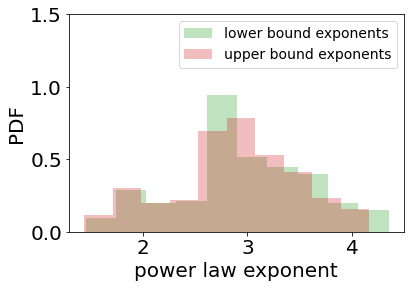

In [121]:
m_LR=wjr['lr_pbc']['m']

#TODO: print apparent powerlaw exponent for these a values
X_proj_LR=X.copy()
amin_LR=8.5950-0.3771
amax_LR=8.5950+0.3771
X_proj_LR[:,-1]=X_proj_LR[:,-1]*0.+amin_LR
mhat_min = interp(X_proj_LR)
X_proj_LR[:,-1]=X_proj_LR[:,-1]*0.+amax_LR
mhat_max = interp(X_proj_LR)
plt.hist(mhat_min,color='C2',alpha=0.3,label='lower bound exponents',density=True)
plt.hist(mhat_max,color='C3',alpha=0.3,label='upper bound exponents',density=True)
format_plot(ax=plt.gca(),xlabel='power law exponent',ylabel='PDF')
plt.legend(fontsize=14)
plt.ylim([0,1.5])
plt.show()

In [122]:
#TODO: print the total number of trials that had an exponent smaller than m_fk
#TODO: print the total number of trials that had an exponent smaller than m_lr
m_LR=wjr['lr_pbc']['m']
m_FK=wjr['fk_pbc']['m']
m_values=df['m'].values
num_exponents_smaller_LR = np.sum(m_values<m_LR)
num_exponents_smaller_FK = np.sum(m_values<m_FK)
num_trials = m_values.shape[0]
print(f"{num_trials=}")
print(f"{num_exponents_smaller_LR=}")
print(f"{num_exponents_smaller_FK=}")

num_trials=4239
num_exponents_smaller_LR=72
num_exponents_smaller_FK=236


In [123]:
# ##### run 24:
# num_trials=4239
# num_exponents_smaller_LR=76
# num_exponents_smaller_FK=260
# ##### run 25:
# num_trials=4239
# num_exponents_smaller_LR=72
# num_exponents_smaller_FK=236

## scratchwerk

In [10]:
# #ordinary least squares is not helpful...
# model_ols =  linear_model.LinearRegression(copy_X=True, fit_intercept=True)#, n_jobs=None, normalize=True)
# # model_ols =  linear_model.LinearRegression(normalize=True)
# model_ols.fit(X,y)
# print('ordinary least squares is not helpful...')
# print(f"results of naive linear fitregression via ordinairy least squares:")
# coef = model_ols.coef_
# intercept = model_ols.intercept_
# print('coef= ', coef)
# print('intercept= ', intercept)

# Rsq=model_ols.score(X,y)
# print(f"Rsquared is {Rsq:.4f}")

# yhat=model_ols.predict(X)
# rmse=np.sqrt(np.mean((yhat-y)**2))
# print(f"rmse is {rmse:.4f}")

In [11]:
#DONE: dev and test an inverse mapping from X_values to x1_values and x2_values
#DONE: apply ^that same inverse mapping to y_values to ygrid_values

#GOAL: make a beautiful analysis for WJR and PM
#DONE: abstract the xaxis, D into x_col
#DONE: in a backwards compatable way, swap a,r with D, and fix D instead
#DONE: fix D=2 and kappa=500 and draw a versus r plot

#DONE: chose reasonable colorbar values
# #DONT(later, brief optimization of ^that colorbar): make the best color-contrasted heatmap plot of m versus a versus r (i.e. are versus-versus-plot abstractions)
# #for fixed D=2
# #for fixed kappa=250 Hz
# # X_mesh=numpy 2d-array of pixel site values for a versus r
# # y_value=the exponent, m. at each pixel site in X_mesh, m has values for the expected exponent from the powerlaw fit
# vmin=avg_value-fwhm_value/2
# vmax=avg_value+fwhm_value/2

#DONE: plot level sets for the m,M from the LR model
#DONE: identify any intersection points

#TODO: plot level sets for the m,M from the FK model
#TODO: identify any intersection points
#TODO: repeat this for each kappa value observed

In [12]:
#TODO(reuse the "genetic: algorithm I used previously that used random linear combinations via interp): guess many values of X that are a boltzman weighted linear combination of the top 6 + some normal error

In [13]:
#DONE: compute a boltzman weighted mean of the top K=6
#DONE: list the parameters r,kappa,D,a:=varkappa that have the closest exponent m to the LR model.  compute the boltzman weighted mean value
#DONE: simulate the particle simulation locally/repeatably for the LR model. record.
#DONE: rescale time such that the overall magnitude of the particle model is consistent with that of the LR model

#TODO: list the parameters r,kappa,D,a:=varkappa that have the closest slope to the FK model
#TODO: simulate the particle simulation locally/repeatably for the FK model. record
#TODO: rescale time such that the overall magnitude of the particle model is consistent with that of the FK model

#DONE: Plot these best fits
#DONE: compute a boltzman weighted mean of the top K=6


In [14]:
#TODO(for visualization): make a nice visualization using the previous method (just put a line plot of m,M versus a for several r values fixed, and an overall D value, also fixed)
#TODO(later? for visualization): make a nice visualization using the new method



# (optional) heatmaps of apparent powerfit parameters on D versus a
- TODO(later): make another data run with more than 3 values of D used
- TODO(later): make these into labeled contour plots

In [15]:
#solution for the r,D,a basis
#restrict to fixed reaction range
r=0.1 #cm
fixed_value=r
fixed_row=0

# unfixed_rows=[1,2]
boo=Xall[:,fixed_row]==fixed_value
X=Xall[boo,1:3].copy()
# X[:,unfixed_rows[0]]=Xall[boo,unfixed_rows[0]].copy()
# X[:,unfixed_rows[1]]=Xall[boo,unfixed_rows[1]].copy()
y=yall[boo].copy()

#define the local grid for visualization of N-dim interpolation
num_cols=X.shape[1]
xi=[]
for i in range(num_cols):
    x=X[:,i]
    xi.append( np.linspace(np.min(x), np.max(x)) )

XI=np.meshgrid(*xi)
print(len(XI))

x1_values=XI[0]
x2_values=XI[1]

# np.array(list(zip(XI))).shape
gridshape=x1_values.shape
X_values=np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,fixed_row,:].T


#TODO: compute the interpolated values of y on this 2D grid
# interp = LinearNDInterpolator(X, y)
interp = CloughTocher2DInterpolator(X, y)
y_values = interp(X_values).reshape(gridshape[0],gridshape[1])
y_values.shape
# ,X_values.shape,x1_values.shape
# y_values.reshape?

NameError: name 'Xall' is not defined

In [ ]:
#plot the interpolated m (left) and the interpolated M (right) for each pixel.
#visualize a versus D
x2lim=[0,30]
# x2lim=[0,110]
x1lim=[0.7,2]#[np.min(x1_values),np.max(x1_values)]
# x1lim=[np.min(x1_values),np.max(x1_values)]
fontsize=15
xlabel=r'$D$ (cm$^2$/s)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool

Xall=dg[input_cols].values 

#define parameters to be varied
input_cols=['r','D','varkappa']#,x0
# input_cols=['r','kappa','D','varkappa']#,x0
# output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

#columnal kwargs
vmin_lst=[1,0]
vmax_lst=[3,30]
# output_col_lst=['Delta_m','Rsq']
output_col_lst=['m','M']
#kwargs by row
r_lst=[0.1,0.2]
fig, axs = plt.subplots(2, len(r_lst), figsize=(16,14))
cmaps = ['RdBu_r', 'viridis']
title_foo=lambda r:f'r = {r:.1f} cm'
nsamples=1000
for col in range(len(output_col_lst)):
    #extract target output value to fit to
    output_col=output_col_lst[col]
    yall=dg[output_col].values
    for row in range(2):
        #restrict to fixed reaction range
        r=r_lst[row]
        title=title_foo(r)#f'r = {r:.1f} cm'
        boo=Xall[:,0]==r
        X=Xall[boo,1:3].copy()  #make the x,y axis the 2nd and 3rd columns of X
        y=yall[boo].copy()
        #TODO: compute the m,M fits
        #TODO: compute the interpolated values of y on this 2D grid
        interp = LinearNDInterpolator(X, y)
        interp = CloughTocher2DInterpolator(X, y)

        #define the local grid for visualization of N-dim interpolation
        num_cols=X.shape[1]
        xi=[]
        for i in range(num_cols):
            x=X[:,i]
            xi.append( np.linspace(np.min(x), np.max(x),nsamples) )

        XI=np.meshgrid(*xi)
        x1_values=XI[0]
        x2_values=XI[1]

        # np.array(list(zip(XI))).shape
        gridshape=x1_values.shape
        X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
        y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
        
        ax = axs[row, col]
        vmin=vmin_lst[col]
        vmax=vmax_lst[col]
#         vmin=np.quantile(y_values.flatten(),0.25)
#         vmax=np.quantile(y_values.flatten(),0.75)
        pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
        
        
#         ax.set_xlim(x1lim)
#         ax.set_ylim(x2lim)
        ax.set_title(title,fontsize=fontsize)
        format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
        
#     fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
# plt.tight_layout()
plt.show()

In [ ]:
#TODO./DONE_up_^there: fit interp on all dimensions

In [ ]:
# x2lim=[0,20]
# x1lim=[np.min(x1_values),np.max(x1_values)]
# fontsize=20
# # xlabel=r'$r$ (cm)'
# xlabel=r'$D$ (cm$^2$/s)'
# ylabel=r'$a$ (cm$^2$/s)'
# vmin=1
# vmax=3
# cmap = mpl.cm.cool

# #TODO:visualize this slice
# fig, ax = plt.subplots(figsize=(6, 4))
# # ax.pcolormesh(x1_values, x2_values, y_values, shading='auto')
# ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmap)


# # # #format for colorbar
# # # # fig.subplots_adjust(bottom=0.5)
# # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# # fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
# #              cax=ax, orientation='vertical', label='exponent value')


# ax.set_xlim(x1lim)
# ax.set_ylim(x2lim)
# format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
# plt.show()

In [ ]:
# x1lim=[0.05,0.5]#r
# x2lim=[0,20]#a
# # x1lim=[0.7,2]#D [np.min(x1_values),np.max(x1_values)]
# # x1lim=[np.min(x1_values),np.max(x1_values)]
# fontsize=15
# xlabel=r'$r$ (cm)'
# xlabel=r'$D$ (cm$^2$/s)'
# # ylabel=r'$a$ (cm$^2$/s)'
# cmap = mpl.cm.cool

# #TODO: compute the interpolated m (left) and the interpolated M (right) for each pixel.
# #HINT: if col==0: # then, get fitted m values
# #HINT: if col==1: # then, get fitted M values


# #define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
# # input_cols=['r','kappa','D','varkappa']#,x0
# # output_col='m'
# #inputs:dg,input_cols,output_col
# #output: fitted model

# Xall=dg[input_cols].values 
# #D=2
# #columnal kwargs
# vmin_lst=[1,0]
# vmax_lst=[3,30]
# output_col_lst=['m','M']
# #kwargs by row
# r_lst=[0.1,0.2]
# colvar_lst=r_lst
# title_foo=lambda r:f'r = {r:.1f} cm'
# # kappa_lst=[250,500]
# # colvar_lst=kappa_lst
# # title_foo=lambda kappa:f'kappa = {kappa:.1f} cm'


In [16]:
#TODO(for visualization): make a nice visualization using the previous method (just put a line plot of m,M versus a for several r values fixed, and an overall D value, also fixed)
#TODO(later? for visualization): make a nice visualization using the new method 


# fix D. fix kappa. Plot the heatmap of m value over a versus r

In [17]:
neighbor=1
# neighbor=0
#define constant parameters
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
kappa=500
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
query_template=query.copy()
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','D','varkappa']#,x0
output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_col].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
yhat = interp(X)
rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of linear interpolation is {rmse:.4f}")

# yhat = interp(X)
print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

NameError: name 'df' is not defined

In [ ]:
D=0.3
# D=2
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[1,50]
# x2lim=[0,50]
fontsize=16
figsize=(11,4.5)#(16,6)#(16,14)
xlabel=r'$r$ (cm)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool
#columnal kwargs
vmin_lst=[1,1]
vmax_lst=[3,3]
# vmin_lst=[1,0]
# vmax_lst=[3,20]
output_col_lst=['m','m']
# output_col_lst=['m','M']
#kwargs by row
# r_lst=[0.1,0.2]
kappa_lst=[250,500]
kappa_col=2
cmaps = ['RdBu_r', 'RdBu_r']
# cmaps = ['RdBu_r', 'viridis']
title_foo=lambda kappa:f'kappa = {kappa:.0f} Hz'
# fig,ax=plt.subplots()
fig,axs=plt.subplots(ncols=2, figsize=figsize)
# fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
# kappa=500
nsamples=1000
col=0
kappa_lst=[250,500]
for col,kappa in enumerate(kappa_lst):
    output_col=output_col_lst[col]
    query = (df['D']==D)
    query&= (df['kappa']==kappa)
    query&= query_template
    X=df.loc[query,['r','varkappa']].values
    y_values=df.loc[query,output_col].values
#     interp = LinearNDInterpolator(X, y_values)
    interp = CloughTocher2DInterpolator(X, y_values)

    #TODO: make interpolator that maps X to y values everywhere
    #TODO: make a grid realization of y_values
    #TODO: how do I compute y_values previously?
    #TODO: could this be as easy as a nested for-loop about each pixel value, running y_values=interp(X[j,:])

    #define the local grid for visualization of N-dim interpolation
    num_cols=X.shape[1]
    xi=[]
    for i in range(num_cols):
        x=X[:,i]
        xi.append( np.linspace(np.min(x), np.max(x),nsamples) )
    XI=np.meshgrid(*xi)
    print(len(XI))
    x1_values=XI[0]
    x2_values=XI[1]

    # np.array(list(zip(XI))).shape
    gridshape=x1_values.shape
    X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
    print(X_values.shape)
    y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    # y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    print((x1_values.shape,x2_values.shape,y_values.shape))
    ax=axs[col]
    #ax = axs[row, col]
    #     #plot heatmap in the next axis
    #     #ax = axs[row, col]
    vmin=vmin_lst[col]
    vmax=vmax_lst[col]
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
#     pcm=ax.pcolormesh(np.log(x1_values+1), np.log(x2_values+1), y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
    ax.set_xlim(x1lim)
    ax.set_ylim(x2lim)
    title=title_foo(kappa)
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, xlabel, ylabel, fontsize, use_loglog=False)
    ax.set_xscale('log')
    ax.set_yscale('log')
    cbar=fig.colorbar(pcm, ax=ax, shrink=0.6,label=output_col)#, location='top'
    # fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    #     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
plt.tight_layout()
plt.show()


In [ ]:
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[1,50]
# x2lim=[0,50]
fontsize=16
figsize=(11,4.5)#(16,6)#(16,14)
xlabel=r'$r$ (cm)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool
#columnal kwargs
# vmin_lst=[1,1]
# vmax_lst=[3,3]
vmin_lst=[0,0]
vmax_lst=[30,30]
output_col_lst=['M','M']
# output_col_lst=['m','M']
#kwargs by row
# r_lst=[0.1,0.2]
kappa_lst=[250,500]
kappa_col=2
# cmaps = ['RdBu_r', 'RdBu_r']
cmaps = ['viridis', 'viridis']
title_foo=lambda kappa:f'kappa = {kappa:.0f} Hz'
# fig,ax=plt.subplots()
fig,axs=plt.subplots(ncols=2, figsize=figsize)
# fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
# D=2.0
# kappa=500
nsamples=1000
col=0
kappa_lst=[250,500]
for col,kappa in enumerate(kappa_lst):
    output_col=output_col_lst[col]
    query = (df['D']==D)
    query&= (df['kappa']==kappa)
    query&= query_template
    X=df.loc[query,['r','varkappa']].values
    y_values=df.loc[query,output_col].values
    interp = LinearNDInterpolator(X, y_values)
    # interp = CloughTocher2DInterpolator(X, y_values)

    #TODO: make interpolator that maps X to y values everywhere
    #TODO: make a grid realization of y_values
    #TODO: how do I compute y_values previously?
    #TODO: could this be as easy as a nested for-loop about each pixel value, running y_values=interp(X[j,:])

    #define the local grid for visualization of N-dim interpolation
    num_cols=X.shape[1]
    xi=[]
    for i in range(num_cols):
        x=X[:,i]
        xi.append( np.linspace(np.min(x), np.max(x),nsamples) )
    XI=np.meshgrid(*xi)
    print(len(XI))
    x1_values=XI[0]
    x2_values=XI[1]

    # np.array(list(zip(XI))).shape
    gridshape=x1_values.shape
    X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
    print(X_values.shape)
    y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    # y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    print((x1_values.shape,x2_values.shape,y_values.shape))
    ax=axs[col]
    #ax = axs[row, col]
    #     #plot heatmap in the next axis
    #     #ax = axs[row, col]
    vmin=vmin_lst[col]
    vmax=vmax_lst[col]
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
#     pcm=ax.pcolormesh(np.log(x1_values+1), np.log(x2_values+1), y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
    ax.set_xlim(x1lim)
    ax.set_ylim(x2lim)
    title=title_foo(kappa)
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, xlabel, ylabel, fontsize, use_loglog=False)
    ax.set_xscale('log')
#     ax.set_yscale('log')
    cbar=fig.colorbar(pcm, ax=ax, shrink=0.6,label=output_col)#, location='top'
    # fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    #     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
plt.tight_layout()
plt.show()


In [18]:
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[1,50]
# x2lim=[0,50]
fontsize=16
figsize=(11,4.5)#(16,6)#(16,14)
xlabel=r'$r$ (cm)'
ylabel=r'$a$ (cm$^2$/s)'
cmap = mpl.cm.cool
#columnal kwargs
# vmin_lst=[1,1]
# vmax_lst=[3,3]
vmin_lst=[0,0]
vmax_lst=[30,30]
output_col_lst=['M','M']
# output_col_lst=['m','M']
#kwargs by row
# r_lst=[0.1,0.2]
kappa_lst=[250,500]
kappa_col=2
# cmaps = ['RdBu_r', 'RdBu_r']
cmaps = ['viridis', 'viridis']
title_foo=lambda kappa:f'kappa = {kappa:.0f} Hz'
# fig,ax=plt.subplots()
fig,axs=plt.subplots(ncols=2, figsize=figsize)
# fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
# D=2.0
# kappa=500
nsamples=1000
col=0
kappa_lst=[250,500]
for col,kappa in enumerate(kappa_lst):
    output_col=output_col_lst[col]
    query = (df['D']==D)
    query&= (df['kappa']==kappa)
    query&= query_template
    X=df.loc[query,['r','varkappa']].values
    y_values=df.loc[query,output_col].values
    interp = LinearNDInterpolator(X, y_values)
    # interp = CloughTocher2DInterpolator(X, y_values)

    #TODO: make interpolator that maps X to y values everywhere
    #TODO: make a grid realization of y_values
    #TODO: how do I compute y_values previously?
    #TODO: could this be as easy as a nested for-loop about each pixel value, running y_values=interp(X[j,:])

    #define the local grid for visualization of N-dim interpolation
    num_cols=X.shape[1]
    xi=[]
    for i in range(num_cols):
        x=X[:,i]
        xi.append( np.linspace(np.min(x), np.max(x),nsamples) )
    XI=np.meshgrid(*xi)
    print(len(XI))
    x1_values=XI[0]
    x2_values=XI[1]

    # np.array(list(zip(XI))).shape
    gridshape=x1_values.shape
    X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
    print(X_values.shape)
    y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    # y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
    print((x1_values.shape,x2_values.shape,y_values.shape))
    ax=axs[col]
    #ax = axs[row, col]
    #     #plot heatmap in the next axis
    #     #ax = axs[row, col]
    vmin=vmin_lst[col]
    vmax=vmax_lst[col]
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
#     pcm=ax.pcolormesh(np.log(x1_values+1), np.log(x2_values+1), y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
    ax.set_xlim(x1lim)
    ax.set_ylim(x2lim)
    title=title_foo(kappa)
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, xlabel, ylabel, fontsize, use_loglog=False)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    cbar=fig.colorbar(pcm, ax=ax, shrink=0.6,label=output_col)#, location='top'
    # fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
    #     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(output_col, fontsize=fontsize)    
plt.tight_layout()
plt.show()

NameError: name 'mpl' is not defined

In [ ]:
# contours = plt.contour(x1_values, x2_values, y_values, 3, colors='black')
# plt.clabel(contours, inline=True, fontsize=8)

# plt.imshow(y_values, extent=[0.05, 0.5, 0, 50], origin='lower',
#            cmap='RdGy', alpha=0.5)
# # plt.colorbar();

In [ ]:
comp_longest_level_set_and_smooth

## der scratchwerk

In [ ]:
# #TODO: for a given local m measure in the r,a plane, compute the lewiner level set for a square lattice via the lookup-table implementation.

# #GOAL: level sets
# #TODO: copy existing method of level sets here!!!
# #heretim





# X.shape,y_values.shape

# #  plot heatmap in the next axis
# #ax = axs[row, col]
# #     vmin=vmin_lst[col]
# #     vmax=vmax_lst[col]
# pcm=ax.pcolormesh(x1_values, x2_values, y_values)#, vmin=vmin, vmax=vmax, cmap=cmaps[col])


# X.shape,x1_values.shape,x2_values.shape,y_values.shape

# #define parameters to be varied
# # input_cols=['r','D','varkappa']#,x0
# input_cols=['r','kappa','D','varkappa']#,x0
# output_col='m'
# #inputs:dg,input_cols,output_col
# #output: fitted model

# #solution for the r,D,a basis
# #restrict to fixed reaction range
# # r=0.1 #cm
# D=2
# fixed_value=D#r
# fixed_row=1

# unfixed_rows=[0,2]
# boo=Xall[:,fixed_row]==fixed_value
# X=Xall[boo,1:3].copy()
# X[:,0]=Xall[boo,unfixed_rows[0]].copy()
# X[:,1]=Xall[boo,unfixed_rows[1]].copy()
# X[:,1]=Xall[boo,unfixed_rows[1]].copy()
# y=yall[boo].copy()

# #define the local grid for visualization of N-dim interpolation
# num_cols=X.shape[1]
# xi=[]
# for i in range(num_cols):
#     x=X[:,i]
#     xi.append( np.linspace(np.min(x), np.max(x)) )

# XI=np.meshgrid(*xi)
# print(len(XI))

# x1_values=XI[0]
# x2_values=XI[1]





#         #heretim
#         X=Xall[boo,1:3].copy()  #make the x,y axis the 2nd and 3rd columns of X
#         y=yall[boo].copy()
#         #TODO: compute the m,M fits
#         #TODO: compute the interpolated values of y on this 2D grid
#         # interp = LinearNDInterpolator(X, y)
#         interp = CloughTocher2DInterpolator(X, y)

#         #define the local grid for visualization of N-dim interpolation
#         num_cols=X.shape[1]
#         xi=[]
#         for i in range(num_cols):
#             x=X[:,i]
#             xi.append( np.linspace(np.min(x), np.max(x)) )
#         XI=np.meshgrid(*xi)
#         x1_values=XI[0]
#         x2_values=XI[1]

#         # np.array(list(zip(XI))).shape
#         gridshape=x1_values.shape
#         X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
#         y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
        
#         ax = axs[row, col]
#         vmin=vmin_lst[col]
#         vmax=vmax_lst[col]
#         pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
       
    
    



# # np.array(list(zip(XI))).shape
# gridshape=x1_values.shape
# X_values=np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T


# #TODO: compute the interpolated values of y on this 2D grid
# # interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
# y_values = interp(X_values).reshape(gridshape[0],gridshape[1])
# y_values.shape
# # ,X_values.shape,x1_values.shape
# # y_values.reshape?

# #visualize a versus r
# x2lim=[0,20]
# x1lim=[0.05,0.5]#[np.min(x1_values),np.max(x1_values)]
# # x1lim=[np.min(x1_values),np.max(x1_values)]
# fontsize=15
# xlabel=r'$r$ (cm)'
# ylabel=r'$a$ (cm$^2$/s)'
# cmap = mpl.cm.cool

# #TODO: compute the interpolated m (left) and the interpolated M (right) for each pixel.
# #HINT: if col==0: # then, get fitted m values
# #HINT: if col==1: # then, get fitted M values

# Xall=dg[input_cols].values 

# #columnal kwargs
# vmin_lst=[1,0]
# vmax_lst=[3,30]
# output_col_lst=['m','M']
# #kwargs by row
# # r_lst=[0.1,0.2]
# kappa_lst=[250,500]
# kappa_col=2
# fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))
# cmaps = ['RdBu_r', 'viridis']
# title_foo=lambda kappa:f'kappa = {kappa:.1f} Hz'

# for col in range(2):
#     #extract target output value to fit to
#     output_col=output_col_lst[col]
#     yall=dg[output_col].values
#     for row in range(2):
#         #restrict to fixed reaction range
#         kappa=kappa_lst[row]
#         title=title_foo(kappa)#f'r = {r:.1f} cm'
#         boo=Xall[:,kappa_col]==kappa
        
        
#         #heretim
#         X=Xall[boo,1:3].copy()  #make the x,y axis the 2nd and 3rd columns of X
#         y=yall[boo].copy()
#         #TODO: compute the m,M fits
#         #TODO: compute the interpolated values of y on this 2D grid
#         # interp = LinearNDInterpolator(X, y)
#         interp = CloughTocher2DInterpolator(X, y)

#         #define the local grid for visualization of N-dim interpolation
#         num_cols=X.shape[1]
#         xi=[]
#         for i in range(num_cols):
#             x=X[:,i]
#             xi.append( np.linspace(np.min(x), np.max(x)) )
#         XI=np.meshgrid(*xi)
#         x1_values=XI[0]
#         x2_values=XI[1]

#         # np.array(list(zip(XI))).shape
#         gridshape=x1_values.shape
#         X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
#         y_values = interp(X_values).reshape(gridshape[0],gridshape[1]) 
        
#         ax = axs[row, col]
#         vmin=vmin_lst[col]
#         vmax=vmax_lst[col]
#         pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmaps[col])
        
        
#         ax.set_xlim(x1lim)
#         ax.set_ylim(x2lim)
#         ax.set_title(title,fontsize=fontsize)
#         format_plot(ax, xlabel, ylabel, fontsize)#, use_loglog=False
        
# #     fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
#     cbar.ax.tick_params(labelsize=fontsize)
#     cbar.set_label(output_col, fontsize=fontsize)    
# # plt.tight_layout()
# plt.show()







# select the top K=6 trials of r,D,a values most reasonable for the powerlaw fits from the full models

## DONE: make this comp_ND_interpolation routine functional and move to lib

In [19]:
# #TODO: move this into lib for the boltzaman weighted mean routine
# def comp_ND_interpolation(dg,input_cols,output_col,**kwargs):
#     """inputs:dg,input_cols,output_col
#         output: fitted model
#     dg=df[query] is a pandas.DataFrame instance assumed to have a unique trial 
#     for any unique combination of fields indicated by input_col
#     define parameters to be varied
#     input_cols=['r','D','varkappa']#,x0
#     input_cols=['r','kappa','D','varkappa']#,x0
    
#     Example Usage:
#     interp=comp_ND_interpolation(dg,input_cols,output_col)
#     """

#     Xall=dg[input_cols].values 
#     yall=dg[output_col].values
#     X=Xall.copy()
#     y=yall.copy()
#     m = len(y) # number of training examples
#     print(f'the number of training examples is {m:d}')
#     try:
#         interp = LinearNDInterpolator(X, y)
#         yhat = interp(X)
#         rmse=np.sqrt(np.mean((yhat-y)**2))
#     except Exception as e:
#         #print('Warning: '+e) #QhullError...
#         interp = LinearNDInterpolator(X, y)
#         yhat = interp(X)
#         rmse=np.sqrt(np.mean((yhat-y)**2))
#     # # interp = CloughTocher2DInterpolator(X, y)
#     # yhat = interp(X)
#     # rmse=np.sqrt(np.mean((yhat-y)**2))
#     print(f"the rmse of ordinairy interpolation is {rmse:.4f}")

#     # #forked from:
#     # interp = LinearNDInterpolator(X, y)
#     # # interp = CloughTocher2DInterpolator(X, y)
#     # yhat = interp(X)
#     # rmse=np.sqrt(np.mean((yhat-y)**2))
#     # print(f"the rmse of simple interpolation is {rmse:.4f}")
#     return interp

#moved to lib.measure.boltzman
# def return_top_k_trials(df,output_col,ytrgt,k=6,**kwargs):
#     """returns k rows that are have an absolute value of df[output_col] closest to ytrgt
#     k=<the number of top trials to return>
#     Example Usage:
#     smallest_deviations=return_top_k_trials(df,output_col,ytrgt,k=k)
#     """
#     unsorted_series=np.abs(df[output_col]-ytrgt)
#     indices_of_sorted=unsorted_series.argsort()
#     smallest_deviations=indices_of_sorted.loc[:k].values
#     return smallest_deviations

In [20]:
# Recall powerlaw fits to full models
# Fenton-Karma(PBC) 
m, Delta_m, M, Delta_M = 1.8772341309722325, 0.02498750277237229, 5.572315674840435, 0.3053120355191732
# Luo-Rudy(PBC) 
m, Delta_m, M, Delta_M = 1.6375562704001745, 0.017190912126700632, 16.73559858353835, 0.8465090320196467

# # Fenton-Karma(NCBC) 
# m, Delta_m, M, Delta_M = 1.854156794480594, 0.02503190538288011, 7.135532649256895, 0.4548432215549294
# # Luo-Rudy(NCBC) 
# m, Delta_m, M, Delta_M = 1.6611400039209043, 0.02740424198712116, 16.75061667963681, 1.3110747548319708


In [21]:
k=6
#load the powerlaw data from the particle model
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/powerlaw_fits_run_15_all.csv"
df=pd.read_csv(input_fn)

# input_cols=['r', 'D', 'varkappa']
input_cols=['r','kappa', 'D', 'varkappa']
output_col='m'
ytrgt=m
# output_col='M'
# ytrgt=M

#TODO: finds the values closest to ytrgt
#define constant parameters
reflect=0
force_code=2
set_second=0
# neighbor=0
no_attraction=0
no_repulsion=0
kappa=500
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

NameError: name 'pd' is not defined

In [ ]:
#compute ND interpolation fit
interp=comp_ND_interpolation(dg,input_cols,output_col)

In [ ]:
#list the top k trials
smallest_deviations=return_top_k_trials(dg,output_col,ytrgt,k=k)
print(f"these are the {k} trials with {output_col} closest to {ytrgt}")
df.loc[smallest_deviations]

## TODO(later): implement genetic algorithm to find the best fit combination of r,D,a:=varkappa for a given kappa


 __Methods__ Method for genetically optimizated fit of the apparent powerlaw. 
 - Step 1: choose best k=2 or 3 for a given set of sample r,D,varkappa,kappa pairs
 - Step 2: generate N=1000 random sample targets centered about the mean of ^these reproducing elite sample values.  Compute predicted output values.
   - Hint: Results may be generated using piecewise linear interpolation for these sammples to save an exceptional amount of computational time.
 - repeat ^these last couple steps some number of times, K.
 - Perform a principle component analysis on the final iterate of ^that sample generation process.
 - select the output vector closest to the desired output value, here (m,M)
 - perform ./return_CollTimes.sh on this parameter value.  Conside improving performance with more iterates of steps 1 and 2.

In [ ]:
# TODO: copy the cells from that genetic dev_run.ipynb 

#TODO: recall from up ^there that I have X,y to fit, for X.shape=(n_samples,n_dimensions:=3)
#TODO: modify ^this to dev a genetic optimization problem 

# __Methods__
# - Step 1: choose best k=2 or 3 for a given set of sample r,D,varkappa,kappa pairs
# - Step 2: generate N=1000 random sample targets centered about the mean of ^these reproducing elite sample values.  Compute predicted output values.
#   - Hint: Results may be generated using piecewise linear interpolation for these sammples to save an exceptional amount of computational time.
# - repeat ^these last couple steps some number of times, K.
# - Perform a principle component analysis on the final iterate of ^that sample generation process.
# - select the output vector closest to the desired output value, here (m,M)
# - perform ./return_CollTimes.sh on this parameter value.  Conside improving performance with more iterates of steps 1 and 2.

#TODO: determine the elite superior
#TODO: make a map from a number of points (K nearest neighbors, wrt m or separately M) to a correlation matrix
#TODO: generate points about the mean randomly using ^that correlation matrix
#TODO: test those points

## scratchwerk

In [22]:
# # interp.tri?
# # Examples
# # --------
# # Triangulation of a set of points:

# points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
# from scipy.spatial import Delaunay
# tri = Delaunay(points)

# # We can plot it:

# import matplotlib.pyplot as plt
# plt.triplot(points[:,0], points[:,1], tri.simplices)
# plt.plot(points[:,0], points[:,1], 'o')
# plt.show()

# # Point indices and coordinates for the two triangles forming the triangulation:
# print(tri.simplices)

# # Note that depending on how rounding errors go, the simplices may
# # be in a different order than above.
# print(points[tri.simplices])
# # Triangle 0 is the only neighbor of triangle 1, and it's opposite to vertex 1 of triangle 1:

# print((tri.neighbors[1],points[tri.simplices[1,1]]))

# # We can find out which triangle points are in:

# p = np.array([(0.1, 0.2), (1.5, 0.5), (0.5, 1.05)])
# print(tri.find_simplex(p))
# # The returned integers in the array are the indices of the simplex the
# # corresponding point is in. If -1 is returned, the point is in no simplex.
# # Be aware that the shortcut in the following example only works corretcly
# # for valid points as invalid points result in -1 which is itself a valid
# # index for the last simplex in the list.

# p_valids = np.array([(0.1, 0.2), (0.5, 1.05)])
# tri.simplices[tri.find_simplex(p_valids)]

# # We can also compute barycentric coordinates in triangle 1 for these points:

# b = tri.transform[1,:2].dot(np.transpose(p - tri.transform[1,2]))
# np.c_[np.transpose(b), 1 - b.sum(axis=0)]

# # The coordinates for the first point are all positive, meaning it
# # is indeed inside the triangle. The third point is on a vertex,
# # hence its null third coordinate.

# boltzmann defect weighting of the K nearest neighbors

- DONE: do ^this with the inverse powerlaw data (force_code==2)
- TODO: convert to functional routine boltzmann defect weighting of the K nearest neighbors
- TODO: move routine to lib.routines
- TODO(later): repeat with reflect==1
- TODO(later): do ^this with the anti-hookean data (force_code==1)

In [23]:
k=6
#load the powerlaw data from the particle model
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/powerlaw_fits_run_15_all.csv"
df=pd.read_csv(input_fn)

# input_cols=['r', 'D', 'varkappa']
input_cols=['r','kappa', 'D', 'varkappa']
output_col='m'
# output_col='M'
# ytrgt=M

#TODO: finds the values closest to ytrgt
#define constant parameters
reflect=0
force_code=2
set_second=0
# neighbor=0
no_attraction=0
no_repulsion=0
kappa=500
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

NameError: name 'pd' is not defined

In [ ]:
#GOAL: dev genetic algorithm using Boltzman Defect Weighting
#DONE: wrap ^this into a function
#TODO: repeat ^this with M
#TODO: return result as dict_out with mtrgt,Mtrgt,K,src,[and outputs]
#TODO: put ^that into an output_vector, (m1,M(m1)) and for the M optimized K=5 elite members, (m(M2),M2).  Then, consider seeding the next generation with a correlation matrix times a normally distributed random variable, plus a  random linear interpolant of the fitting points for the K=5 elite of m1_values and M2_values

In [ ]:
# #TODO: 
# m1_values=df.loc[smallest_deviations, output_col].values
# # TODO: and M2_values

# output_values=m1_values

# #TODO: find the values closest to m
# ytrgt=M
# k=20
# input_cols=['r','kappa', 'D', 'varkappa']
# output_col='m'

In [ ]:
# Recall powerlaw fits to full models
# Fenton-Karma(PBC) 
m, Delta_m, M, Delta_M = 1.8772341309722325, 0.02498750277237229, 5.572315674840435, 0.3053120355191732
wjr={
    'fk_pbc':{'m':m, 'Delta_m':Delta_m, 'M':M, 'Delta_M':Delta_M}
}
# Luo-Rudy(PBC) 
m, Delta_m, M, Delta_M = 1.6375562704001745, 0.017190912126700632, 16.73559858353835, 0.8465090320196467
wjr['lr_pbc']={'m':m, 'Delta_m':Delta_m, 'M':M, 'Delta_M':Delta_M}
print(*wjr)

In [24]:
unsorted_series=np.abs(dg[output_col]-ytrgt)
indices_of_sorted=unsorted_series.argsort()
smallest_deviations=indices_of_sorted.loc[:k-1].values
#         boo=unsorted_series.index.values==unsorted_series.loc[smallest_deviations[0]].values[0]
#         for sd in smallest_deviations[1:]:
#             sdd=unsorted_series.iloc[sd].values[0]
#             boo|=unsorted_series.index.values==sdd
#     print(df.loc[smallest_deviations,cols])
#compute the boltzmann weighted mean m
output_disagreement_values=unsorted_series.iloc[indices_of_sorted].values[:k-1]#df.loc[boo,output_col].values
boltzman_weighted_mean=comp_boltzman_weighted_mean(output_disagreement_values)#,**kwargs)
boltzman_weighted_mean

NameError: name 'dg' is not defined

In [ ]:
# routine for Boltzman Defect Weighting
# (weight_values*elite_parameter_values[:,1]**2).shape
k=6
input_cols=['r','kappa', 'D', 'varkappa']
# model_name_lst=['fk_pbc','lr_pbc','fk_ncbc', 'lr_ncbc']
output_col_lst=['m','M']

dict_bwm=compute_boltzman_defect_weighted_mean_for_top_k(df=dg,k=6)
df_bwm=pd.DataFrame(dict_bwm)
df_bwm.head(12)

In [25]:
#print the bwm parameter value
input_param_bwm=df_bwm.T.loc['fk_pbc_m',input_cols].values
df_bwm.T.loc['fk_pbc_m',input_cols]

NameError: name 'df_bwm' is not defined

In [ ]:
ytrgt=m
output_col='m'
unsorted_series=np.abs(df[output_col]-ytrgt)
indices_of_sorted=unsorted_series.argsort()
input_param_values=df.loc[indices_of_sorted,input_cols].head(k).values
# unsorted_series[indices_of_sorted.values].values
# output_disagreement_values=unsorted_series.loc[indices_of_sorted.values].values[:k-1]
# output_disagreement_values

In [26]:
#DONE: perform PCA on the top k outputs minus the parameter mean
from sklearn.decomposition import PCA
X=input_param_values-np.mean(input_param_values,axis=0)
pca = PCA(n_components=input_param_values.shape[1])
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

NameError: name 'input_param_values' is not defined

In [ ]:
# print(f"somethings not right if the best for the fk_pbc model has zero for all fields...")
dict_bwm=compute_boltzman_defect_weighted_mean_for_top_k(df=dg,k=4)
# df_bwm=pd.DataFrame(compute_boltzman_defect_weighted_mean_for_top_k(df=dg,k=2))
df_bwm.head()
print(df_bwm['fk_pbc_m'])

In [ ]:
# #compute the linear ND interpolating function mapping the parameter space to the output m space, restricting to 4 variables
#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','D','varkappa']#,x0
output_col='m'
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_col].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
yhat = interp(X)
rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of simple interpolation is {rmse:.4f}")

# yhat = interp(X)
print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

In [ ]:
#DONE: compute m boltzman weighted average as m1
#DONE: compute M boltzman weighted average as M2
#DONE: compute interp for the full parameter space as above
#TODO: dev compute_M(m1) via interpolation near output_cols=(r,kappa,D,varkappa) using interp
#TODO: dev compute_m(M2) using interp

#TODO: plot the linear interpolation of m,M using plt.plot()
# print(list(zip((model_name_lst,output_col_lst,m1avg_lst,M2avg_lst))))

print(dict_bwm['fk_pbc_m'])
print(f"""the boltzman weighted mean exponent fitted to the Luo-Rudy model was
m_lr_observed_bwm :{dict_bwm['fk_pbc_m']['m']:.5f} +- {dict_bwm['fk_pbc_m']['Delta_m']:.5f}
m_lr_expected_wjr : {wjr['fk_pbc']['m']:.5f} +- {wjr['fk_pbc']['Delta_m']:.5f}

With mean parameters

""")

#TODO: compute the two points
#TODO: interpolate as boltzman_weighted_mean
#TODO: dev compute_boltzman_weighted_cov... Hint: check numpy.linalg.
#TODO: using interp, generate 1000 novel offspring... and also include the original line in the coming progeny...

In [ ]:
r=dict_bwm['fk_pbc_m']['r']
r

# plot the top 1 trials for either full model
- using a log(w) versus log(q) plot 
- with particle data scatterplotted to overlay the powerlaw fits of the full models
- wrap ^this functionally into a function that takes an input ax,df_particle_drates and plots the scatterplot data and the fit
- generate a run_15_top_6.pdf using bluf.py

In [29]:
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all.csv"
# df_raw=pd.read_csv(input_fn)
# #derived values
# df_raw['CollRate']=1./df_raw['CollTime']
df_raw=df.copy()
df_raw['A']=df_raw['L']**2
df_raw['q']=df_raw['N']/df_raw['A'] #number of tips per square centimeter
df_raw['w']=df_raw['CollRate']/df_raw['A'] #[mHz?]/cm^2

KeyError: 'CollRate'

In [ ]:
k=0#for k in range(len(smallest_deviations_lst[0])):
trial_index_1=smallest_deviations_lst[0][k]
trial_index_2=smallest_deviations_lst[1][k]

In [ ]:
#compute the powerlaw fitted values for the k^th best exponent (i) with and (ii) without scaling
# FK model
x_values=np.linspace(0.1,1,91)
d=df.loc[trial_index_1]
yhat1=d['M']*x_values**d['m']
yhat1_scaled=wjr['fk_pbc']['M']*x_values**d['m']
scale_factor1=wjr['fk_pbc']['M']/d['M']

#computation of tscores
t_m_FK=(wjr['fk_pbc']['m']-d['m'])/np.max((wjr['fk_pbc']['Delta_m'],d['Delta_m']))
print(f"t_m_FK={t_m_FK:.5f}")

#query the DataFrame for this d
query =(df_raw.set_second==d['set_second'])&(df_raw.reflect==d['reflect'])
query&=(df_raw.no_repulsion==d['no_repulsion'])&(df_raw.no_attraction==d['no_attraction'])
query&=(df_raw.neighbor==int(d['neighbor']))&(df_raw.force_code==int(d['force_code']))
query&=df_raw.r==d['r']
query&=df_raw.kappa==d['kappa']
query&=df_raw.D==d['D']
query&=df_raw.L==d['L']
query&=df_raw.varkappa==d['varkappa']
query&=df_raw.x0==d['x0']
dg=df_raw[query]
#and extract the xy values
x1_values=dg.q.values
y1_values=dg.w.values
y1_scaled_values=y1_values*scale_factor1

#LR model
d=df.loc[trial_index_2]
yhat2=d['M']*x_values**d['m']
yhat2_scaled=wjr['lr_pbc']['M']*x_values**d['m']
scale_factor2=wjr['lr_pbc']['M']/d['M']

#computation of tscores
t_m_LR=(wjr['lr_pbc']['m']-d['m'])/np.max((wjr['lr_pbc']['Delta_m'],d['Delta_m']))
print(f"t_m_LR={t_m_LR:.5f}")

#query the DataFrame for this d
query =(df_raw.set_second==d['set_second'])&(df_raw.reflect==d['reflect'])
query&=(df_raw.no_repulsion==d['no_repulsion'])&(df_raw.no_attraction==d['no_attraction'])
query&=(df_raw.neighbor==int(d['neighbor']))&(df_raw.force_code==int(d['force_code']))
query&=df_raw.r==d['r']
query&=df_raw.kappa==d['kappa']
query&=df_raw.D==d['D']
query&=df_raw.L==d['L']
query&=df_raw.varkappa==d['varkappa']
query&=df_raw.x0==d['x0']
dg=df_raw[query]
#and extract the xy values
x2_values=dg.q.values
y2_values=dg.w.values
y2_scaled_values=y2_values*scale_factor2

In [ ]:
80*0.03,4*2.22 #cm^2/s attractive force magnitude
500*0.03,250*2.22 #Hz reaction rate
1.6*0.03,1.3*2.22 #cm^2/s diffusion coefficient

In [ ]:
#plot fits for full model
m_fk=wjr['fk_pbc']['m']
m_lr=wjr['lr_pbc']['m']
M_fk=wjr['fk_pbc']['M']# Hz*cm^{2(m-1)}
M_lr=wjr['lr_pbc']['M']# Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)

xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

yscale=10**3
fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)

#plot particle model for the FK model
plt.scatter(x1_values,y1_values,label=f'(#{k+1} exponent found for FK model)',c='C3',alpha=0.3)
plt.plot(x_values,yhat1,label=f'powerlaw fit, particle model',c='C3',alpha=.7,zorder=3,lw=3)

#plot particle model for the LR model
plt.scatter(x2_values,y2_values,label=f'(#{k+1} exponent found for LR model)',c='C4',alpha=0.3)
plt.plot(x_values,yhat2,label=f'powerlaw fit, particle model',c='C4',alpha=.7,zorder=3,lw=3)


# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5,ncol=2,loc='upper left')
plt.show()

In [ ]:
#plot fits for full model, with time rescaling
m_fk=wjr['fk_pbc']['m']
m_lr=wjr['lr_pbc']['m']
M_fk=wjr['fk_pbc']['M']# Hz*cm^{2(m-1)}
M_lr=wjr['lr_pbc']['M']# Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)

xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

yscale=10**3
fontsize=16
# plt.xlim([0.1,1])
plt.ylim([5e-2,80])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)

#plot particle model for the FK model
plt.scatter(x1_values,y1_scaled_values,label=f"particle model setting A",c='C3',alpha=0.3)
# plt.scatter(x1_values,y1_scaled_values,label=f'(#{k+1} exponent found for FK model\nrescaled by M_new/M_old={scale_factor1:.2f}',c='C3',alpha=0.3)
# plt.scatter(x1_values,y1_scaled_values,label=f'(#{k+1} exponent found for FK model,\nrescaled time)',c='C3',alpha=0.3)
# plt.plot(x_values,yhat1_scaled,label=f'powerlaw fit, particle model,\nrescaled by M_new/M_old={scale_factor1:.2f}',c='C3',alpha=.7,zorder=3,lw=3)

#plot particle model for the LR model
plt.scatter(x2_values,y2_scaled_values,label=f"particle model setting B",c='C4',alpha=0.3)
# plt.scatter(x2_values,y2_scaled_values,label=f'(#{k+1} exponent found for LR model,\nrescaled by M_new/M_old={scale_factor2:.2f}',c='C4',alpha=0.3)
# plt.scatter(x2_values,y2_scaled_values,label=f'(#{k+1} exponent found for LR model,\nrescaled time)',c='C4',alpha=0.3)
# plt.plot(x_values,yhat2_scaled,label=f'powerlaw fit, particle model,\nrescaled by M_new/M_old={scale_factor2:.2f}',c='C4',alpha=.7,zorder=3,lw=3)


# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5,ncol=2,loc='upper left')
plt.show()

In [ ]:
d=df.loc[trial_index_1]
print(f"printing results for particle model fit to FK model")
boo=(x1_values>=0.2)&(x1_values<=1.0)
print_fit_power_law(x1_values[boo],y1_scaled_values[boo])
print(f"^this particle model used parameters:")
print(d[input_cols])

d=df.loc[trial_index_2]
print(f"\nprinting results for particle model fit to LR model")
boo=(x2_values>=0.2)&(x2_values<=1.0)
print_fit_power_law(x2_values[boo],y2_scaled_values[boo])
print(f"^this particle model used parameters:")
print(d[input_cols])

In [ ]:
# print(d)

# dev functionally automating level set computing on the m heatmaps of a versus r

In [ ]:
# #TODO: move this to lib_care.measure
# #TODO: These were copied to lib.measure... and lib_care.measure and care/lib.measure
# def comp_largest_level_set(array,level,txt):
#     #extract the contour in pixel coordinates
#     contours=find_contours(array=array, level=level, fully_connected='low', positive_orientation='low', mode='hard_boundary')#, *, mask=None)
#     num_contours=len(contours)
#     assert(num_contours>0)
#     minsize=0
#     for contour_any in contours:
#         if contour_any.shape[0]>minsize:
#             minsize=contour_any.shape[0]
#             contour=contour_any
#     # plt.plot(contour[:,1],contour[:,0])

#     #map pixel coordinates to input coordinates using bilinear interpolation
#     #doubling kwargs width and height effectively nullifies the periodic boundary conditions used in interpolate_txt_to_contour by default
#     width=2*array.shape[0]
#     height=2*array.shape[1]
#     contour_values=np.array(interpolate_txt_to_contour(contour,width,height,txt=txt))[1:]#[1:] fixes bug from periodic boundary conditions
#     return contour_values

In [ ]:
# from inspect import getsource
# print (
#     getsource(moving_average))
# find_contours

In [ ]:
# def smooth_contour_xy(contour_values,navg=20,xcol=0,ycol=1):
#     '''returns contour smoothed by a simple moving average with a moving window length of navg nodes/values.
#     uses <function lib_care.measure.compute_forces_at_annihilation.moving_average(x, w)>, which should be moved to lib_care.measure.moving_average.py
#     Example Usage:
#     x_smoothed,y_smoothed=smooth_contour_xy(contour_values,w=20)
#     '''
#     x=contour_values[:,xcol]
#     y=contour_values[:,ycol]
#     x_smoothed=moving_average(x,w=navg)
#     y_smoothed=moving_average(y,w=navg)
#     return x_smoothed,y_smoothed

# def smooth_contour(contour_values,navg=20):
#     '''returns contour smoothed by a simple moving average with a moving window length of navg nodes/values.
#     uses <function lib_care.measure.compute_forces_at_annihilation.moving_average(x, w)>, which should be moved to lib_care.measure.moving_average.py
#     Example Usage:
#     smoothed_contour_value_lst=smooth_contour(contour_values,navg=20)
#     '''
#     smoothed_contour_value_lst=[]
#     for col in range(contour_values.shape[1]):
#         x=contour_values[:,col]
#         x_smoothed=moving_average(x,w=navg)
#         smoothed_contour_value_lst.append(x_smoothed)
#     return smoothed_contour_value_lst

In [ ]:
# def comp_meshgrid_from_X(X,nsamples=1000):
#     #define the local grid for visualization of N-dim interpolation
#     num_cols=X.shape[1]
#     xi=[]
#     for i in range(num_cols):
#         x=X[:,i]
#         xi.append( np.linspace(np.min(x), np.max(x),nsamples) )
#     XI_lst=np.meshgrid(*xi)
#     return XI_lst

# def comp_coordinate_values_from_X(X,nsamples=1000):
#     XI_lst=comp_meshgrid_from_X(X,nsamples=nsamples)
#     x1_values=XI_lst[0]
#     x2_values=XI_lst[1]
#     return x1_values, x2_values

In [ ]:
# def interp_txt_from_scatter(X,y,nsamples=1000,mode ='spline',**kwargs):
#     '''input: X,y,nsamples=1000:
#         - (N,2) numpy array as X, (N,1) numpy array as y
#         - mode='spline' uses CloughTocher2DInterpolator, which recieves kwargs
#         - mode='linear' uses LinearNDInterpolator, which recieves kwargs
#     output: x1_values,x2_values,y_values
    
#     Example Usage:
#     x1_values,x2_values,y_values=interp_txt_from_scatter(X,y)
#     '''
#     if mode == 'linear':
#         interp = LinearNDInterpolator(X, y,**kwargs)
#     elif mode == 'spline':
#         interp = CloughTocher2DInterpolator(X, y,**kwargs)
#     else:
#         pass
#         raise(f"Warning: mode={mode} is not yet implemented!")

#     #compute the xy coordinate images
#     x1_values, x2_values = comp_coordinate_values_from_X(X,nsamples=nsamples)

#     #compute the target value images
#     gridshape=x1_values.shape
#     X_values =np.array(list(zip((x1_values.flatten(),x2_values.flatten()))))[:,0,:].T
#     y_values = interp(X_values).reshape(gridshape[0],gridshape[1])
#     return x1_values,x2_values,y_values

In [ ]:
# def comp_longest_level_set_and_smooth(X,y,level,navg=20):
#     '''returns the navg-moving average xy coordinates of the level-set 
#     curve where y(X)=level that has the most segments.
#     - X is an N by 2 numpy array
#     - y is an N by 1 numpy array
#     Example Usage:
#     output_col='m'; model_name='lr_pbc'
#     level=wjr[model_name][output_col]
#     y=df.loc[query,output_col].values
#     smoothed_contour_values=comp_longest_level_set(X,y,level,navg=20)
#     '''
    
    
#     x1_values,x2_values,y_values=interp_txt_from_scatter(X,y)
#     txt=np.stack((x1_values,x2_values)).T

#     #TODO(later, add support for measuring M, Delta_M along the m-level set): concat txt from all output arrays of interest at once
#     #- compute the y_values for each target output variable
#     # - stack y_value_lst at the end as a txt
#     #HINT: modify to use only first 2 axis XI_lst=comp_meshgrid_from_X(X) where X is N by D, for D channels you want the value for along the contour
#     # ###### MemoryError: Unable to allocate 6.94 EiB for an array with shape (1000, 1000, 1000, 1000, 1000, 1000) and data type float64 
#     # #interpolate any desired fields to txt
#     # field_txt_col_lst=[x1_col,x2_col,'m','Delta_m','M','Delta_M']
#     # X=df.loc[query,field_txt_col_lst].values
#     # XI_lst=comp_meshgrid_from_X(X)
#     # txt=np.stack(XI_lst).T

#     #interpolate the smoothed contour values
#     array=y_values
#     contour_values=comp_largest_level_set(array,level,txt)
#     x_smoothed,y_smoothed=smooth_contour_xy(contour_values,navg=navg)
#     smoothed_contour_values=np.stack((x_smoothed,y_smoothed)).T
#     #re: ###### MemoryError: Unable to allocate 6.94 EiB 
#     # smoothed_contour_value_lst=smooth_contour(contour_values,navg=20)
#     return smoothed_contour_values

# compute ar_star settings
- to visualize level set curves set to powerlaw fits from the full models
- TODO: move functions to lib.viewer

In [ ]:
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
from lib.lib_care.measure.level_sets import compute_self_consistent_astar_rstar

In [ ]:
def PlotInterpolatedBackground(fig,ax,x1_values,x2_values,y_values,vmin,vmax,clabel,cmap,fontsize=16,show_cbar=True,**kwargs):
    output_col=clabel
    pcm=ax.pcolormesh(x1_values, x2_values, y_values, vmin=vmin, vmax=vmax, cmap=cmap,**kwargs)
    if use_cbar:
        cbar=fig.colorbar(pcm, ax=ax, shrink=0.6,label=output_col)#, location='top'
        # fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
        #     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
        cbar.ax.tick_params(labelsize=fontsize)
        cbar.set_label(output_col, fontsize=fontsize)
    return True

def FormatAxes(ax,x1lim,x2lim,x1label,x2label,title,fontsize=16,use_loglog=False,**kwargs):        
    ax.set_xlim(x1lim)
    ax.set_ylim(x2lim)
    ax.set_title(title,fontsize=fontsize)
    format_plot(ax, x1label, x2label, fontsize=fontsize, use_loglog=use_loglog,**kwargs)
    return True

In [ ]:
# Recall powerlaw fits to full models
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

In [ ]:
#load the map between input parameters and emergent observables
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)

#define constant parameters
neighbor=1
# neighbor=0
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
query_template=query.copy()

In [ ]:
df.head()

In [ ]:
#compute the contour values for fk_pbc and lr_pbc and record the intersections in df_star
x1_col='r'
x2_col='varkappa'
nsamples=1000
navg=50
mode='spline'#'linear'
printing=False
# D=2
# D_lst=[2,0.7,14]
D_lst=sorted(set(df.D.values))[::-1]
print(f"D_lst={D_lst}")
kappa_lst=sorted(set(df.kappa.values))[::-1]
print(f"iterating over kappa_lst={kappa_lst} and the PBC full model results...")
dict_out_lst=[]
#FK model
model_name='fk_pbc'
for D in D_lst:
    for kappa in kappa_lst:
        query = (df['D']==D)
        query&= (df['kappa']==kappa)
        query&= query_template
        X=df.loc[query,[x1_col,x2_col]].values

        #computation of level set curves set to powerlaw fits from the full models
        if printing:
            print(f"for the {model_name} model, when kappa={kappa:.0f} Hz and D={D:.2f} cm^2/s...")
        output_col='m'
        m=float(wjr[model_name][output_col])
        y=df.loc[query,output_col].values
        try:
            contour_m_values=comp_longest_level_set_and_smooth(X,y,level=m,navg=navg)
        except AssertionError as e:#assert(num_contours>0)
            contour_m_values=None
        output_col='M'
        M=float(wjr[model_name][output_col])
        y=df.loc[query,output_col].values
        try:
            contour_M_values=comp_longest_level_set_and_smooth(X,y,level=M,navg=navg)
        except AssertionError as e:#assert(num_contours>0)
            contour_M_values=None
        
        if (contour_m_values is not None) and (contour_M_values is not None):
            contour_m_values_LR=contour_m_values.copy()
            contour_M_values_LR=contour_M_values.copy()

            try:
                #compute the self-consistent intersection points
                rstar,astar=compute_self_consistent_astar_rstar(contour_m_values,contour_M_values)
            except AssertionError as e:#assert (x1star_values.shape[0]>0)
                rstar=np.nan
                astar=np.nan
        else:
            rstar=np.nan
            astar=np.nan

        #collect results into a dictionary
        dict_out={
            'model_name':model_name,
            'rstar':rstar,
            'astar':astar,
            'kappa':kappa,
            'D':D,
            'm':m,
            'M':M
        }
        # append that dict to list
        dict_out_lst.append(dict_out)
#LR model
model_name='lr_pbc'
for D in D_lst:
    for kappa in kappa_lst:
        query = (df['D']==D)
        query&= (df['kappa']==kappa)
        query&= query_template
        X=df.loc[query,[x1_col,x2_col]].values

        if printing:
            print(f"for the {model_name} model, when kappa={kappa:.0f} Hz and D={D:.2f} cm^2/s...")

        output_col='m'
        m=float(wjr[model_name][output_col])
        y=df.loc[query,output_col].values
        try:
            contour_m_values=comp_longest_level_set_and_smooth(X,y,level=m,navg=navg)
        except AssertionError as e:#assert(num_contours>0)
            contour_m_values=None
        output_col='M'
        M=float(wjr[model_name][output_col])
        y=df.loc[query,output_col].values
        try:
            contour_M_values=comp_longest_level_set_and_smooth(X,y,level=M,navg=navg)
        except AssertionError as e:#assert(num_contours>0)
            contour_M_values=None
        
        if (contour_m_values is not None) and (contour_M_values is not None):
            contour_m_values_LR=contour_m_values.copy()
            contour_M_values_LR=contour_M_values.copy()

            try:
                #compute the self-consistent intersection points
                rstar,astar=compute_self_consistent_astar_rstar(contour_m_values,contour_M_values)
            except AssertionError as e:#assert (x1star_values.shape[0]>0)
                rstar=np.nan
                astar=np.nan
        else:
            rstar=np.nan
            astar=np.nan
        #collect results into a dictionary
        dict_out={
            'model_name':model_name,
            'rstar':rstar,
            'astar':astar,
            'kappa':kappa,
            'D':D,
            'm':m,
            'M':M
        }
        # append that dict to list
        dict_out_lst.append(dict_out)

df_star=pd.DataFrame(dict_out_lst)
print(df_star.head())

In [ ]:
# df_star[df_star=='fk_pbc']
df_star.dropna()

In [ ]:
df_star.dropna(inplace=True)
df_star[df_star.D==0.3].tail()

In [ ]:
df_star[df_star.D==0.7].tail()

In [ ]:
#DONE: iterate over models and kappas of interest
#DONE: format dict_out_lst into df_star
#TODO: save df_star to .csv

printing=True
save_folder=None
save_fn=None
saving=True
# if printing:
#     print(f"parsing absolute directory of input_fn={input_fn}...")
input_folder=os.path.dirname(input_fn)
trial_folder_name=os.path.dirname(input_folder)
if save_folder is None:
    save_folder=input_folder
if save_fn is None:
    save_fn = os.path.basename(input_fn).replace('_all_powerlaw_fits.csv','_ar_star.csv')

if saving:
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    os.chdir(save_folder)
    df_star.to_csv(save_fn,index=False)
    save_fn=os.path.abspath(save_fn)
    if printing:
        print(f"self-consistent intersection parameters were successfully saved to \n{save_fn}")
#     intersection_dir=save_fn

In [ ]:
# play with ar_star

In [ ]:
df_star.iloc[-1].copy().astar

In [ ]:
#TODO: extract from single lines/rows print(df_star) to format a string of the form
# dff=df_star.iloc[-1].copy()
c_folder=f"{nb_dir}/../c/attractive"
os.chdir(c_folder)
for i in range(1,5):
    sim_str=f"date; ./xrun.sh {df_star.iloc[-i].rstar:.6f} {df_star.iloc[-i].D:.6f} 10 {df_star.iloc[-i].kappa} {df_star.iloc[-i].astar:.6f} 0 1e-5 1e-5 100 1500 1234 0 0 0 0 1 2 > Log/out.{df_star.iloc[-i].name}"
    print (sim_str)

In [ ]:
# intersection_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_ar_star.csv'
intersection_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_ar_star.csv'
intersection_dir_neighbors='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_ar_star.csv'
df_star=pd.read_csv(intersection_dir)
df_star.head()

# Example computation of an rstar and astar pair

In [ ]:
def compute_powerlaw_contours(df,D,kappa,query_template,x1_col='r',x2_col='varkappa',model_name='fk_pbc',
                              navg=5,#50,
                              **kwargs):
    query = (df['D']==D)
    query&= (df['kappa']==kappa)
    query&= query_template
    X=df.loc[query,[x1_col,x2_col]].values


    output_col='m'
    level=wjr[model_name][output_col]
    y=df.loc[query,output_col].values
    contour_m_values=comp_longest_level_set_and_smooth(X,y,level,navg=navg)

    output_col='M'
    level=wjr[model_name][output_col]
    y=df.loc[query,output_col].values
    contour_M_values=comp_longest_level_set_and_smooth(X,y,level,navg=navg)
    return contour_m_values,contour_M_values

#TODO: compute the contours for the full models
#FK model
D=0.7
# D=2
# kappa=400
kappa=250
# kappa=500
contour_m_values_FK,contour_M_values_FK=compute_powerlaw_contours(df,D,kappa,query_template,x1_col='r',x2_col='varkappa',model_name='fk_pbc',
                              navg=50)
contour_m_values_LR,contour_M_values_LR=compute_powerlaw_contours(df,D,kappa,query_template,x1_col='r',x2_col='varkappa',model_name='lr_pbc',
                              navg=50)
#     contour_m_values_FK=contour_m_values.copy()
#     contour_M_values_FK=contour_M_values.copy()


In [ ]:
#visualize the level sets
#compute the data for background image 
query = (df['D']==D)
query&= (df['kappa']==kappa)
query&= query_template

#TODO: make plotting the background colored image functional
#visualize a versus r
x1lim=[0.05,0.5]
x2lim=[1,50]
# x2lim=[0,50]
fontsize=16
x1label=r'$r$ (cm)'
x2label=r'$a$ (cm$^2$/s)'

title_foo=lambda kappa,D:r'$\kappa$'+f' = {kappa:.0f} Hz, D = {D:.1f} '+r'cm$^2$/s'+f'\n'
title=title_foo(kappa,D)
lw=3
alpha=0.7
cmap = 'gray'#'bone'  #'RdBu_r'#'Greys'# 
use_cbar=True
show_cbar =True
use_loglog=True

kwargs={}

figsize=(11,4.5)#(6,4.5)#(16,6)#(16,14)
fig,axs=plt.subplots(ncols=2, figsize=figsize)

#DONE: plot fig. A contours for m
ax=axs[0]
output_col='m'
vmin=1
vmax=3
X=df.loc[query,['r','varkappa']].values
y=df.loc[query,output_col].values
x1_values,x2_values,y_values=interp_txt_from_scatter(X,y,nsamples=1000)
# clabel=output_col
clabel=r'$\nu$'

PlotInterpolatedBackground(fig,ax,x1_values,x2_values,y_values,vmin,vmax,clabel,cmap,fontsize=fontsize,show_cbar=show_cbar,**kwargs)
FormatAxes(ax,x1lim=x1lim,x2lim=x2lim,x1label=x1label,x2label=x2label,title=title,fontsize=fontsize,use_loglog=use_loglog,**kwargs)      

#DONE: plot the level sets and color them for the full models
ax.plot(contour_m_values_FK[:,0],contour_m_values_FK[:,1],'-',lw=lw,alpha=alpha,c='C0',**kwargs)
ax.plot(contour_m_values_LR[:,0],contour_m_values_LR[:,1],'-',lw=lw,alpha=alpha,c='C1',**kwargs)

#DONE: plot fig. B contours for M
ax=axs[1]
output_col='M'
vmin=0
vmax=30
X=df.loc[query,['r','varkappa']].values
y=df.loc[query,output_col].values
x1_values,x2_values,y_values=interp_txt_from_scatter(X,y,nsamples=1000)
clabel=output_col

PlotInterpolatedBackground(fig,ax,x1_values,x2_values,y_values,vmin,vmax,clabel,cmap,fontsize=fontsize,show_cbar=show_cbar,**kwargs)
FormatAxes(ax,x1lim=x1lim,x2lim=x2lim,x1label=x1label,x2label=x2label,title=title,fontsize=fontsize,use_loglog=use_loglog,**kwargs)      

#DONE: plot the level sets and color them for the full models
ax.plot(contour_M_values_FK[:,0],contour_M_values_FK[:,1],'--',lw=lw,alpha=alpha,c='C0',**kwargs)
ax.plot(contour_M_values_LR[:,0],contour_M_values_LR[:,1],'--',lw=lw,alpha=alpha,c='C1',**kwargs)

plt.tight_layout()
plt.show()

In [ ]:
#compute intersection points
rstar_FK,astar_FK=compute_self_consistent_astar_rstar(contour_m_values_FK,contour_M_values_FK)
rstar_LR,astar_LR=compute_self_consistent_astar_rstar(contour_m_values_LR,contour_M_values_LR)
# use_loglog=True

In [ ]:
#plot fig. C
marker = '*'#'s'
marker_size=400
alpha=0.7
figsize=(5,4.5)#(16,6)#(16,14)
fig,ax=plt.subplots(ncols=1, figsize=figsize)

#visualize the smoothed contour values and verify that they are reasonable
ax.plot(contour_m_values_FK[:,0],contour_m_values_FK[:,1],'-',lw=lw,c='C0')#,**kwargs)
ax.plot(contour_M_values_FK[:,0],contour_M_values_FK[:,1],'--',lw=lw,c='C0')#,**kwargs)
ax.plot(contour_m_values_LR[:,0],contour_m_values_LR[:,1],'-',lw=lw,c='C1')#,**kwargs)
ax.plot(contour_M_values_LR[:,0],contour_M_values_LR[:,1],'--',lw=lw,c='C1')#,**kwargs)


#plot the intersection point
plt.scatter(x = [rstar_FK,rstar_LR], y = [astar_FK,astar_LR], c='k', s=marker_size,zorder=3, marker = marker,alpha=alpha)#, cmap=cmap, vmin=vmin, vmax=vmax)

#scatter plot the intersection points 
FormatAxes(ax,x1lim=x1lim,x2lim=x2lim,x1label=x1label,x2label=x2label,title=title,fontsize=fontsize,use_loglog=use_loglog,**kwargs)      
plt.tight_layout()
plt.show()

In [ ]:
# # #automatically assign axis limits to show the smallest cover
# # lims=df_star.describe().T[['min','max']]
# # xlim=lims.loc['kappa'].values
# # rlim=lims.loc['rstar'].values
# # alim=lims.loc['astar'].values
# # D=lims.loc['D'].values[-1];print(f"max(D)={D} cm^2/s")
# #custom axis limits
# xlim=[200,600]
# rlim=[0.05,0.2]
# alim=[1.5,15]
# D=2

In [ ]:
#TODO: plot df_star versus kappa
#plot fig. D,E
D=2
fontsize=16
use_loglog=False

#custom axis limits
xlim=[200,550]
rlim=[0.01,0.25]
alim=[0,15]
#axis labels
xlabel=r'$\kappa$ (Hz)'
rlabel=r'$r^*$ (cm)'
alabel=r'$a^*$ (cm$^2$/s)'
title=''
marker = '*'#'s'
marker_size=400
alpha=0.7
figsize=(6,5)#(16,6)#(16,14)
fig,axs=plt.subplots(nrows=2, figsize=figsize)
#visualize the smoothed contour values and verify that they are reasonable

#FK model
c='C0'
query =df_star['model_name']=='fk_pbc'
query&=df_star['D']==D
dff=df_star[query]
a_values=dff['astar'].values
r_values=dff['rstar'].values
kappa_values=dff['kappa'].values
#plot
ax=axs[0]
ax.plot(kappa_values,a_values,'-',lw=lw,c=c)#,**kwargs)
ax.scatter(x = kappa_values,y=a_values, c='k', s=marker_size,zorder=3, marker = marker,alpha=alpha)#, cmap=cmap, vmin=vmin, vmax=vmax)
ax=axs[1]
ax.plot(kappa_values,r_values,'-',lw=lw,c=c)#,**kwargs)
ax.scatter(x = kappa_values,y=r_values, c='k', s=marker_size,zorder=3, marker = marker,alpha=alpha)#, cmap=cmap, vmin=vmin, vmax=vmax)

#LR model
c='C1'
query =df_star['model_name']=='lr_pbc'
query&=df_star['D']==D
dff=df_star[query]
a_values=dff['astar'].values
r_values=dff['rstar'].values
kappa_values=dff['kappa'].values
#plot
ax=axs[0]
ax.plot(kappa_values,a_values,'-',lw=lw,c=c)#,**kwargs)
ax.scatter(x = kappa_values,y=a_values, c='k', s=marker_size,zorder=3, marker = marker,alpha=alpha)#, cmap=cmap, vmin=vmin, vmax=vmax)
ax=axs[1]
ax.plot(kappa_values,r_values,'-',lw=lw,c=c)#,**kwargs)
ax.scatter(x = kappa_values,y=r_values, c='k', s=marker_size,zorder=3, marker = marker,alpha=alpha)#, cmap=cmap, vmin=vmin, vmax=vmax)

# format the plots
FormatAxes(axs[0],x1lim=xlim,x2lim=alim,x1label=xlabel,x2label=alabel,title=title,fontsize=fontsize,use_loglog=use_loglog,**kwargs)      
FormatAxes(axs[1],x1lim=xlim,x2lim=rlim,x1label=xlabel,x2label=rlabel,title=title,fontsize=fontsize,use_loglog=use_loglog,**kwargs)      
plt.tight_layout()
plt.show()


In [ ]:
#DONE: repeat for other full model
#DONE: plot the 2 curves
#DONE: plot the intersection point
#DONE: make a reasonable figure
#DONE: automate some reasonable plotting
#DONE: repeat for other kappa
#DONE: plot rstar,astar versus kappa
#DONE: repeat for FK
#TODO: finish this multi-paneled figure!!!!!!!!!!!!!!!
#TODO: make a nice paneled figure crystalizing all these results!
#TODO: share!
#TODO(later?): do these results change when reflect==1?
#TODO: consider starting a new run 16 testing a few more kappa values

In [ ]:
#DONE: crystalize ^this into a function that takes x1_values,x2_values,y_values, and level, and returns the contour xy values
#TODO: get the orange contour for M
#TODO: compute the intersection point where m and M self consistently describe this model as r*,a*, rstar, astar
# rstar, astar=??
#TODO: repeat at another kappa
#TODO: plot kappa versus r*,a*


In [ ]:
# single_panel ploting #DONE: plot fig. B contours for M
# output_col='M'
# vmin=0
# vmax=30

## output_col='m'
## vmin=1
## vmax=3

# #compute the data for background image 
# query = (df['D']==D)
# query&= (df['kappa']==kappa)
# query&= query_template
# X=df.loc[query,['r','varkappa']].values
# y=df.loc[query,output_col].values
# x1_values,x2_values,y_values=interp_txt_from_scatter(X,y,nsamples=1000)

# #TODO: make plotting the background colored image functional
# #visualize a versus r
# x1lim=[0.05,0.5]
# x2lim=[1,50]
# # x2lim=[0,50]
# fontsize=16
# x1label=r'$r$ (cm)'
# x2label=r'$a$ (cm$^2$/s)'
# # #columnal kwargs
# # vmin_lst=[1,1]
# # vmax_lst=[3,3]
# # vmin_lst=[1,0]
# # vmax_lst=[3,20]
# # output_col_lst=['m','m']
# # output_col_lst=['m','M']
# #kwargs by row
# # r_lst=[0.1,0.2]
# kappa_lst=[250,500]

# title_foo=lambda kappa:f'kappa = {kappa:.0f} Hz\n'
# title=title_foo(kappa)
# clabel=output_col
# lw=3
# alpha=0.7
# cmap = 'bone'  #'gray'#'RdBu_r'#'Greys'# 
# cmap = 'gray'#'bone'  #'RdBu_r'#'Greys'# 

# use_cbar=True
# use_loglog=False

# kwargs={}

# figsize=(6,4.5)#(16,6)#(16,14)
# fig,ax=plt.subplots(ncols=1, figsize=figsize)
# # fig,axs=plt.subplots(ncols=2, figsize=figsize)
# # fig, axs = plt.subplots(2, len(kappa_lst), figsize=(16,14))

# PlotInterpolatedBackground(fig,ax,x1_values,x2_values,y_values,vmin,vmax,clabel,cmap,fontsize=fontsize,show_cbar=True,**kwargs)
# FormatAxes(ax,x1lim=x1lim,x2lim=x2lim,x1label=x1label,x2label=x2label,title=title,fontsize=fontsize,use_loglog=True,**kwargs)      

# #DONE: plot the level sets and color them for the full models
# plt.plot(contour_M_values_FK[:,0],contour_M_values_FK[:,1],'--',lw=lw,alpha=alpha,c='C0',**kwargs)
# plt.plot(contour_M_values_LR[:,0],contour_M_values_LR[:,1],'--',lw=lw,alpha=alpha,c='C1',**kwargs)

# #TODO(later): compute and scatter plot the intersection points 
# #HINT rstar,astar=compute_self_consistent_astar_rstar(contour_m_values,contour_M_values)

# plt.tight_layout()
# plt.show()

In [ ]:
#TODO: finish this multi-paneled figure!!!!!!!!!!!!!!!
#TODO(later): automate generating the .csv of all the powerlaw fits... also, change the output location to somewhere central.  record src in some .json file
#TODO: dev function that repeatably generates ^this multi-paneled-figure into a fig_X.pdf




In [ ]:
# TODO: print the Rsq of some of the D=0.3 astar values... they're good.that's a good (Rsq>0.98) check THUMBS UP

In [ ]:
df_star[df_star.D==0.3].head(10)
df[df.D==0.3].head(10)

# (optional) compute boltzmann weighted averages, where the weights are the mean squared error with respect to the smallest of the full models.

In [ ]:
# intersection_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_ar_star.csv'
intersection_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_ar_star.csv'
df_star=pd.read_csv(intersection_dir)
df_star.head()

In [ ]:
dict_bwm=compute_boltzman_defect_weighted_mean_for_top_k(df=dg,k=6)
# dict_bwm=compute_boltzman_defect_weighted_mean_for_top_k(df=dg,k=6)
df_bwm=pd.DataFrame(dict_bwm)
df_bwm.head(12)

In [ ]:
#     return dict_bwm
# from inspect import getsource
# print  (   getsource(compute_boltzman_defect_weighted_mean_for_top_k
#                     ))
# def compute_boltzman_defect_weighted_mean_for_top_k(df,input_cols=['r','kappa', 'D', 'varkappa'],output_col_lst=['m','M'],model_name_lst=None,k=6,printing=False,**kwargs):
#TODO: convert compute_boltzman_defect_weighted_mean_for_top_k to compute_boltzman_defect_weighted_mean_for_msemin no.... minmse roflcopter hahalolz
def compute_boltzman_defect_weighted_mean_et_alii(df,num_to_include,**kwargs):
    k=num_to_include
    '''df=df_input[query] is a pandas.DataFrame instance assumed to have a unique trial
    for any unique combination of fields indicated by input_col
    #TODO: dev compute pca / correlation matrix about the mean
    #TDOO: use ^this correlation matrix to inspire random sampling clouds between the bwm of the top k trials for (i) m and (ii) M.

    Example Usage:
    df_bwm=pd.DataFrame(compute_boltzman_defect_weighted_mean_for_top_k(df=dg))
    df_bwm.head()
    '''
    input_cols=['r', 'kappa', 'D', 'varkappa']
    output_col_lst=['m', 'M']
    model_name_lst=None
    df=df.reindex().copy()
    cols=list(input_cols)
    cols.extend(output_col_lst)

    wjr=recall_powerlaw_fits_to_full_models()
    if printing:
        print(f"recalled from lib the powerlaw fits for full models:")
        print(*wjr)

    if model_name_lst is None:
        model_name_lst=list(wjr.keys())

    m1avg_lst=[]
    M2avg_lst=[]
    dict_bwm={} #dictiionary of boltzmann weighted mean values
    dict_pca={}
    smallest_deviations_lst=[]
    model_name_lst=['fk_pbc','lr_pbc']
    #for 2-dimensional target space, such as m,M
    for model_name in model_name_lst:
        Ytrgt=(wjr[model_name][output_col_lst[0]],wjr[model_name][output_col_lst[1]])
        #for m
        ytrgt=Ytrgt[0]
        output_col=output_col_lst[0]
#         print(f"\nprinting the {k} indices closest to {output_col}={ytrgt} using Ytrgt={Ytrgt}")
        unsorted_series=np.abs(df[output_col]-ytrgt)
        indices_of_sorted=unsorted_series.argsort()
        smallest_deviations=indices_of_sorted.loc[:k-1].values
#         boo=unsorted_series.index.values==unsorted_series.loc[smallest_deviations[0]].values[0]
#         for sd in smallest_deviations[1:]:
#             sdd=unsorted_series.iloc[sd].values[0]
#             boo|=unsorted_series.index.values==sdd
    #     print(df.loc[smallest_deviations,cols])
        #compute the boltzmann weighted mean m
        output_disagreement_values=unsorted_series.iloc[indices_of_sorted].values[:k-1]#df.loc[boo,output_col].values
        boltzman_weighted_mean=comp_boltzman_weighted_mean(output_disagreement_values,**kwargs)
    #     print(f"the boltzman_weighted_mean for the K={k} elite members was {boltzman_weighted_mean}")
        M2avg_lst.append(boltzman_weighted_mean)

        #compute the boltzmann weighted average w.r.t. m
        weight_values=comp_boltzman_weighted_weights(output_disagreement_values,**kwargs)
#         elite_parameter_values=df.loc[boo].values#,cols]
        elite_parameter_values=df.iloc[indices_of_sorted].values[:k-1]
        dict_out=dict(zip(list(df.columns),np.sum(weight_values*elite_parameter_values.T,axis=1)))
        dict_out['top_trial_index']=int(smallest_deviations[0])
        dict_bwm[model_name+f'_{output_col}']=dict_out
        if printing:
            print(f"the boltzman_weighted mean parameter for the K={k} elite members was {dict_out}")

        Xcentered_values=output_disagreement_values-boltzman_weighted_mean
#         Xsvd_values=np.linalg.svd(Xcentered_values)
        corrcoeff_values=np.corrcoef(Xcentered_values)
        #for M
        ytrgt=Ytrgt[1]
        output_col=output_col_lst[1]
    #     print(f"\nprinting the {k} indices closest to M={ytrgt}")
        unsorted_series=np.abs(df[output_col]-ytrgt)
        indices_of_sorted=unsorted_series.argsort()
        smallest_deviations=indices_of_sorted.loc[:k-1].values
#         boo=unsorted_series.index.values==unsorted_series.loc[smallest_deviations[0]].values[0]
#         for sd in smallest_deviations[1:]:
#             sdd=unsorted_series.iloc[sd].values[0]
#             boo|=unsorted_series.index.values==sdd
    #     print(df.loc[smallest_deviations,cols])
        #compute the boltzmann weighted mean m
        output_disagreement_values=unsorted_series.iloc[indices_of_sorted].values[:k-1]#df.loc[boo,output_col].values
        boltzman_weighted_mean=comp_boltzman_weighted_mean(output_disagreement_values,**kwargs)
    #     print(f"the boltzman_weighted_mean for the K={k} elite members was {boltzman_weighted_mean}")
        M2avg_lst.append(boltzman_weighted_mean)

        #compute the boltzmann weighted average w.r.t. m
        weight_values=comp_boltzman_weighted_weights(output_disagreement_values,**kwargs)
#         elite_parameter_values=df.loc[boo].values#,cols]
        elite_parameter_values=df.iloc[indices_of_sorted].values[:k-1]
        dict_zip=dict(zip(list(df.columns),np.sum(weight_values*elite_parameter_values.T,axis=1)))
        dict_out={}
        dict_out[model_name+f'_top_trial_index']=int(smallest_deviations[0])
        dict_bwm[model_name+f'_{output_col}']=dict_out
        dict_out[model_name+f'_corrcoeff']=corrcoeff_values.copy()
#         dict_out[model_name+f'_svd']=Xsvd_values.copy()
        dict_out[model_name+f'_output_disagreement_values']=output_disagreement_values.copy()
        dict_out[model_name+f'_dict_zip']=dict_zip
    #     print(f"the boltzman_weighted mean parameter for the K={k} elite members was {dict_out}")
    return dict_bwm,dict_out,dict_zip #,smallest_deviations_lst

In [ ]:
#DONE: compute the mean squared differences amongst either of the full models and then take the minimum.
#TODO: take random linear combinations in the interpolating space and take the max 1000 randomly seeded values
#TODO: generate ^that many random samples in d dimensions

In [ ]:
kwargs={
}
dict_bwm,dict_out=compute_boltzman_defect_weighted_mean_et_alii(df=df_star,num_to_include=6,**kwargs)
compute_boltzman_defect_weighted_mean_et_alii(
    dg,#df,
#     input_cols=['r', 'kappa', 'D', 'varkappa'],
#     output_col_lst=['m', 'M'],
#     model_name_lst=None,
    num_to_include=6,
    printing=False
#     **kwargs,
)
df_bwm=pd.DataFrame(dict_bwm)
df_bwm.head(12)

In [ ]:
print(*dict_out)
df_star.head()

In [ ]:
# dict_bwm

# (optional) figure out which of the randomly generated interpolants of the star values looks the best for either model.  consider all rows in df_star

In [ ]:
#TODO: merge and move to dev run .ipynb
# intersection_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_ar_star.csv'
intersection_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_ar_star.csv'
df_star=pd.read_csv(intersection_dir)
# df_star.head()

input_cols=['rstar', 'kappa', 'D', 'astar']
output_col_lst=['m', 'M']
X=df_star[input_cols].values
num_stars=X.shape[0]

#TODO: make a num_samples by num_stars matrix
num_samples=10000
rarr=np.random.random(size=(num_samples,num_stars))
# DONT: #TODO: normalize rarr.  this obliterates convex information space sampled
# rarr=np.matmul(rarr,np.ones(rarr.shape[1]))
# rarr.shape,np.sum(rarr,axis=1)
random_parameter_values=np.matmul(rarr,X)
#augment with arr
r_values,kappa_values,D_values,varkappa_values=np.concatenate((X,random_parameter_values)).T

#later #TODO: augment the 4 bwm parameters
# df_bwm

# #TODO: augment with corrcoeff_values projected onto 4x4






In [ ]:
#TODO: fix Delta_M to be correct.  is it significantly larger?

In [ ]:
from inspect import getsource
# print(getsource(LinearNDInterpolator))
LinearNDInterpolator('a')